In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import coffea.hist as hist
matplotlib.rcParams['figure.figsize'] = [15, 8]
matplotlib.rcParams.update({'font.size': 16})
import scipy
import scipy.optimize
from scipy.interpolate import CubicSpline, UnivariateSpline, splrep, BSpline
from scipy.optimize import curve_fit, fsolve, fmin
from landaupy import landau, langauss
import pylandau
import functools
import math
import numba
import bitstruct.c as bitstruct
import copy
import pyroot as root
from multiprocessing import Pool

In [2]:
def getDataRaw(fnames):
    N64BWORDS = 1440
    #N64BWORDS = 1536
    times_320 = []
    times = []
    data = []
    format_time320=bitstruct.compile("u64")
    format_time=bitstruct.compile("u64")
    format_header=bitstruct.compile("u16p48")
    format_accheader=bitstruct.compile("u56u8")
    format=bitstruct.compile("u12"*(256*30))
    #format=bitstruct.compile("p4u12u12u12u12u12"*(256*int(30/5)))
    swapformat="8"*(N64BWORDS)
    for fname in fnames:
        print(fname)
        times_320_lf = []
        times_lf = []
        data_lf = []

        with open(fname, "rb") as f:
            line = f.read((1+4+N64BWORDS)*8)
            lnum = 0
            while len(line) == (1+4+N64BWORDS)*8:
                acc_header = format_accheader.unpack(bitstruct.byteswap("8", line[0*8:1*8]))
                header = format_header.unpack(bitstruct.byteswap("8", line[1*8:2*8]))
                lnum += 1
                if acc_header[0] != 0x123456789abcde or header[0] != 0xac9c:
                    print("CORRUPT EVENT!!! ", lnum, "%x"%acc_header[0], "%x"%header[0])
                    line = f.read((1+4+N64BWORDS)*8)
                    continue
                times_320_lf.extend(format_time320.unpack(bitstruct.byteswap("8", line[2*8:3*8])))
                times_lf.extend(format_time320.unpack(bitstruct.byteswap("8", line[3*8:4*8])))
                data_lf.extend(format.unpack(bitstruct.byteswap(swapformat, line[5*8:])))
                line = f.read((1+4+N64BWORDS)*8)
        data.append(np.array(data_lf))
        times.append(np.array(times_lf))
        times_320.append(np.array(times_320_lf))
    data = np.hstack(data)
    times = np.hstack(times)
    times_320 = np.hstack(times_320)
    return times_320.reshape([-1,]), times.reshape([-1,]), data.reshape([-1, 30, 256])

def getData(fnames):
    data = []
    for fname in fnames:
        with open(fname) as f:
            for line in f:
                data.extend(line.split()[1:31])
    data = np.array(data, dtype='float')
    return data.reshape([-1, 256, 30])    

In [3]:
#_, _, ped_data = getDataRaw(["data/Raw_testData_20230209_115535_b1.txt",])
#times_320, times, data = getDataRaw(["data/Raw_testData_20230209_115328_b1.txt",])

#_, _, ped_data = getDataRaw(["data/ACC_RawData_ACDC61_Run759_Raw.dat",])

#times_320, times, data = getDataRaw(["data/ACC_RawData_ACDC61_Run760_Raw.dat",
#                                    ])

#_, _, ped_data = getDataRaw(["data/Raw_testData_ACC1_20230714_093238_b0.txt",])
_, _, ped_data = getDataRaw(["data/Raw_CounterTest_20230927_133303_b1.txt",])

times_320, times, data = getDataRaw([
    #10 V photocathode 
#    "data/Raw_testData_ACC2_20230714_091716_b0.txt",
#    "data/Raw_testData_ACC2_20230714_091928_b0.txt",
#    "data/Raw_testData_ACC2_20230714_091957_b0.txt",
#    "data/Raw_testData_ACC2_20230714_092102_b0.txt",
#    "data/Raw_testData_ACC2_20230714_092253_b0.txt",
#    "data/Raw_testData_ACC2_20230714_092536_b0.txt",
#    "data/Raw_testData_ACC2_20230714_092620_b0.txt",
#    "data/Raw_testData_ACC2_20230714_092824_b0.txt",
#    "data/Raw_testData_ACC2_20230714_092904_b0.txt",
    #50 V photocathode
#    "data/Raw_testData_ACC1_20230714_094355_b0.txt",
    "data/Raw_testData_ACC1_20230714_094508_b0.txt",
#    "data/Raw_testData_ACC1_20230714_094640_b0.txt",
#    "data/Raw_testData_ACC1_20230714_094737_b0.txt",
#    "data/Raw_testData_ACC1_20230714_094940_b0.txt",
#    "data/Raw_testData_ACC1_20230714_095032_b0.txt",
#    "data/Raw_testData_ACC1_20230714_095229_b0.txt",
#    "data/Raw_testData_ACC1_20230714_095300_b0.txt",
#    "data/Raw_testData_ACC1_20230714_095543_b0.txt",
    #100 V photocathode 
#    "data/Raw_testData_ACC1_20230714_101639_b0.txt",
#    "data/Raw_testData_ACC1_20230714_103133_b0.txt",
#    "data/Raw_testData_ACC1_20230714_103220_b0.txt",
#    "data/Raw_testData_ACC1_20230714_103336_b0.txt",
])

#LAPPD 128 proton data 
#times_320, times, data = getDataRaw([
#    "data/Raw_testData_20230615_165809_b0.txt",
#                                    "data/Raw_testData_20230615_170251_b0.txt",
#                                    "data/Raw_testData_20230615_170538_b0.txt",
#                                    "data/Raw_testData_20230615_170611_b0.txt",
#                                    "data/Raw_testData_20230615_170652_b0.txt",
#                                    "data/Raw_testData_20230615_171647_b0.txt",
#                                    "data/Raw_testData_20230615_172201_b0.txt",
#                                    "data/Raw_testData_20230615_172402_b0.txt",
#                                    "data/Raw_testData_20230616_103643_b0.txt",
#"data/Raw_testData_20230616_103849_b0.txt",
#"data/Raw_testData_20230616_104214_b0.txt",
#"data/Raw_testData_20230616_105420_b0.txt",
#"data/Raw_testData_20230616_105540_b0.txt",
#"data/Raw_testData_20230616_105742_b0.txt",
#"data/Raw_testData_20230616_105951_b0.txt",
#"data/Raw_testData_20230616_111420_b0.txt",
#"data/Raw_testData_20230616_111459_b0.txt",
#"data/Raw_testData_20230616_111724_b0.txt"
#                                    ])

#LAPPD 86 data
#times_320, times, data = getDataRaw(["data/Raw_testData_20230509_170900_b1.txt",
#                                    "data/Raw_testData_20230509_170943_b1.txt",
#                                    "data/Raw_testData_20230509_171547_b1.txt",
#                                    "data/Raw_testData_20230509_171727_b1.txt"])

#LAPPD 86 data
#10 GeV pion
#times_320, times, data = getDataRaw(["data/Raw_testData_20230509_141434_b1.txt",
#                                     "data/Raw_testData_20230509_141942_b1.txt",
#                                     "data/Raw_testData_20230509_144317_b1.txt",
#                                     "data/Raw_testData_20230509_145159_b1.txt",
#                                     "data/Raw_testData_20230509_150105_b1.txt"])
#times_320, times, data = getDataRaw(["data/Raw_testData_20230131_131810_b1.txt",
#                                     "data/Raw_testData_20230131_132417_b1.txt",
#                                     "data/Raw_testData_20230131_132523_b1.txt",
#                                     "data/Raw_testData_20230131_144819_b1.txt"
#                                    ])

#LAPPD 86 data
#_, _, ped_data = getDataRaw(["data/Raw_testData_20230202_144100_b1.txt",])
#times_320, times, data = getDataRaw(["data/Raw_testData_20230202_163840_b1.txt",
#                                     "data/Raw_testData_20230202_172916_b1.txt",
#                                     "data/Raw_testData_20230202_174417_b1.txt",
#                                     "data/Raw_testData_20230202_175022_b1.txt"
#                                    ])

data/Raw_CounterTest_20230927_133303_b1.txt
data/Raw_testData_ACC1_20230714_094508_b0.txt


In [4]:
#averages = np.zeros(ped_data.mean(0).shape)
averages = ped_data.mean(0)
stddevs = ped_data.std(0)
#averages = averages.transpose()

hi


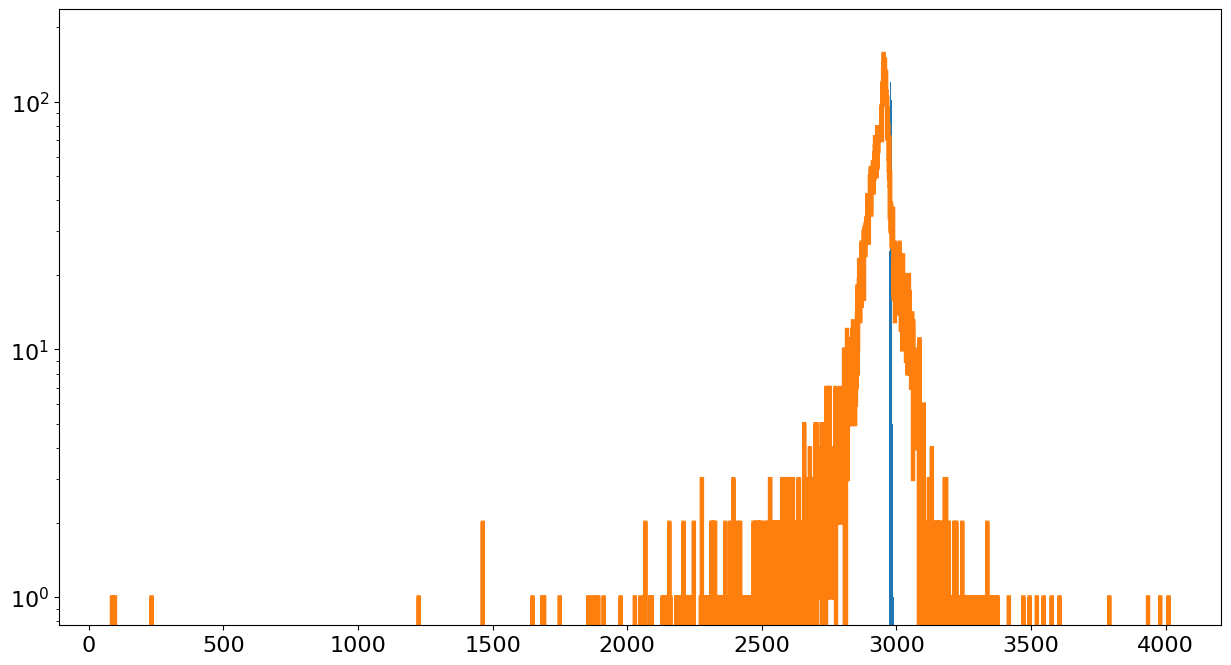

In [5]:
cap = 10
chan = 22
min = ped_data[:,chan,cap].min()
max = ped_data[:,chan,cap].max()+1
plt.hist(ped_data[:,chan,cap], bins=np.linspace(min, max, max-min+1))
min = data[:,chan,cap][data[:,chan,cap]>10].min()
max = data[:,chan,cap].max()+1
plt.hist(data[:,chan,cap], histtype='step', linewidth=3, bins=np.linspace(min, max, max-min+1))
#plt.hist(data[:200,chan,cap], histtype='step', linewidth=2, bins=np.linspace(min, max, max-min+1), label="1")
#plt.hist(data[200:400,chan,cap], histtype='step', linewidth=2, bins=np.linspace(min, max, max-min+1), label="2")
#plt.hist(data[400:600,chan,cap], histtype='step', linewidth=2, bins=np.linspace(min, max, max-min+1), label="3")
#plt.hist(data[600:800,chan,cap], histtype='step', linewidth=2, bins=np.linspace(min, max, max-min+1), label="4")
#plt.hist(data[800:1000,chan,cap], histtype='step', linewidth=2, bins=np.linspace(min, max, max-min+1), label="5")
#plt.axvline(ped_data[:,21,cap].mean(), color="red")
#plt.legend()
plt.yscale("log")
print("hi")

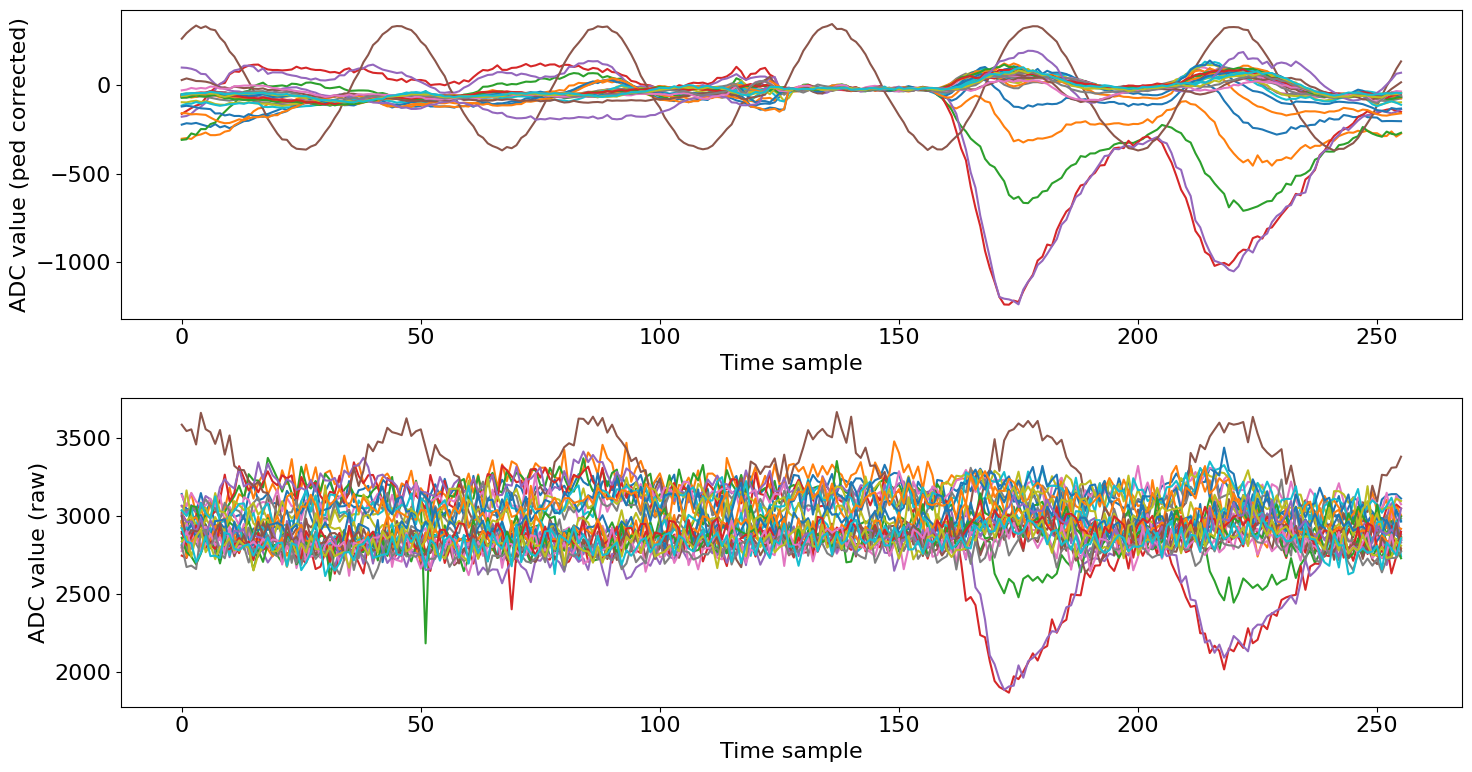

In [6]:
def sine(x, A, B, omega, phi):
    return A * np.sin(omega*x + phi) + B

#channel = 1
#channel_pulse = np.array([5, 11,17,23,29])
#channel_pulse = np.array([0,1,2,3,4,5])+6*4
channel_pulse = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])
#channel_pulse = np.array([0,6,12,18,24])
#channel_pulse = np.array([24,25,26,27,28,29])
event = 10

xdata = np.linspace(0, 255,256)
#ydata = data[event,channel,:]-averages[channel,:]
#ydata_raw = data[event,channel,:] - data[event,channel,:].mean()
ydata_pulse = data[event,channel_pulse,:]-averages[channel_pulse,:]
ydata_pulse_raw = data[event,channel_pulse,:]# - data[event,channel,:].mean()

fig, (ax1, ax2) = plt.subplots(2, 1)
for i, d in enumerate(ydata_pulse):
    ax1.plot(xdata, d, label="Pulse %i"%i)
ax1.set_xlabel("Time sample")
ax1.set_ylabel("ADC value (ped corrected)")

#ax2.plot(xdata, ydata_raw, label="250 MHz sine")
for i, d in enumerate(ydata_pulse_raw):
    ax2.plot(xdata, d, label="Pulse %i"%i)
#ax2.legend()
ax2.set_xlabel("Time sample")
ax2.set_ylabel("ADC value (raw)")

fig.tight_layout()



[115 171]
   extrema [115.06762122]
bs extrema [-1488.52392702]
se extrema 115.06762122391427
   extrema [171.71568194]
bs extrema [-1202.36182069]
se extrema 171.71568194379395
5.532037179675752
5.46875
[11.23707239 16.76910956]
[11.23046875 16.69921875]


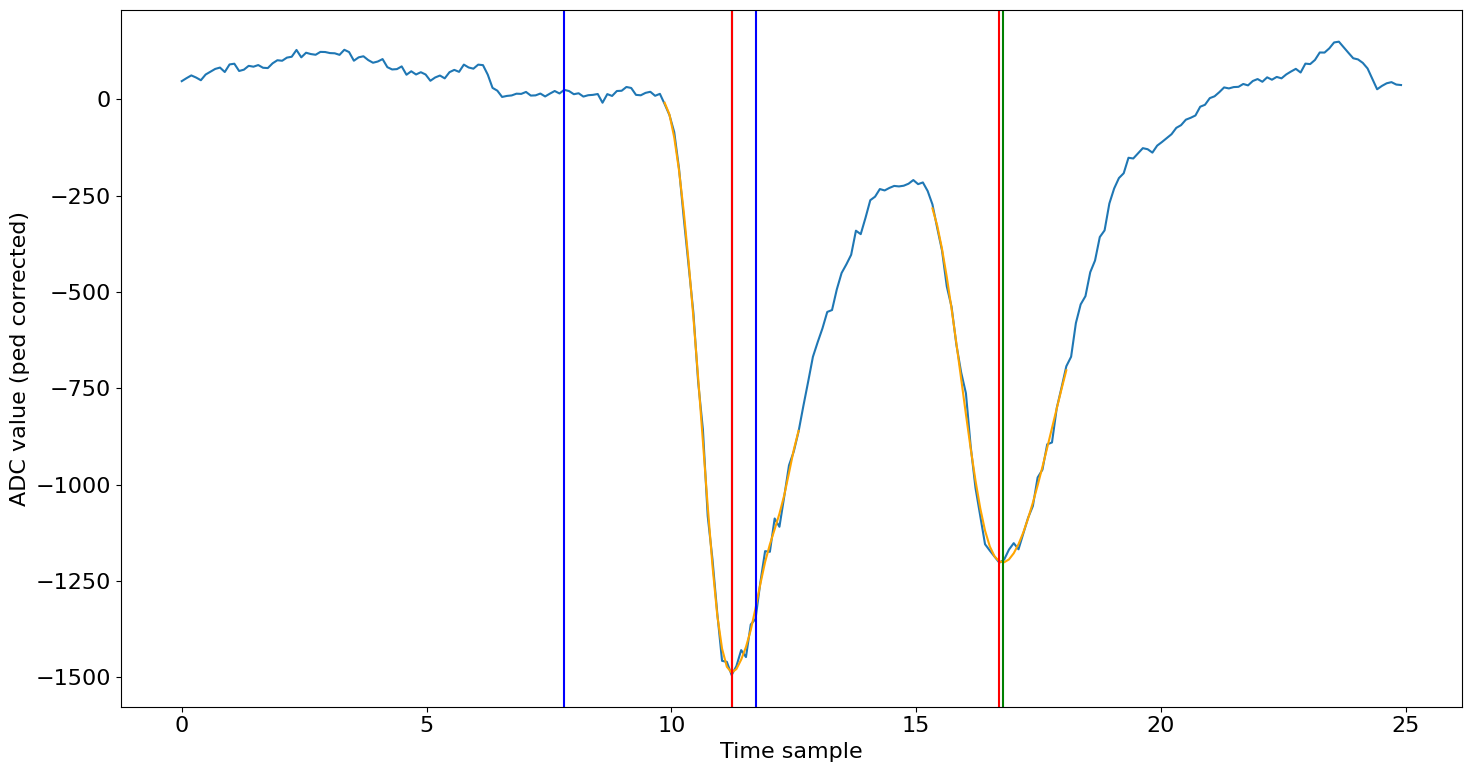

In [11]:
event = 2241

xdata = np.linspace(0, 255,256)
ydata = data[event,:,:]-averages[:,:]

channel = ydata.min(axis=1).argmin()

ydata = ydata[channel]

peaks2 = scipy.signal.find_peaks(-1*ydata, height=(-0.5)*ydata.min(), distance = 20)[0]

peaks = []
csl = []
print(peaks2)
for xp1 in peaks2:
    #xp1 = peaks2.min()
    xp1Cut = (xdata > (xp1-15)) & (xdata < (xp1+15))
    spl = splrep(xdata[xp1Cut], ydata[xp1Cut], k=3, s=10000)
    bs = BSpline(*spl)
    dbs = bs.derivative()
    #print(dcs.solve(0))
    xplot = np.linspace(xp1-15, xp1+15, 100)
    dcs = CubicSpline(xplot, dbs(xplot))
    extrema = dcs.solve(0)
    extrema = extrema[(extrema > (xp1-12)) & (extrema < (xp1+12))]
    print("   extrema", extrema)
    print("bs extrema", bs(extrema))
    extrema = extrema[bs(extrema).argsort()][0]
    print("se extrema", extrema)
    peaks.append(extrema)
    csl.append((xdata[xp1Cut], bs))
peaks = np.array(peaks)
peaks = peaks[(peaks > 0) & (peaks < 256)]
peaks = peaks[np.argsort(bs(peaks))[:2]]

peaks = peaks*25/256
peaks2 = peaks2*25/256

try:
    print(peaks.max()-peaks.min())
    print(peaks2.max()-peaks2.min())
except:
    pass

print(peaks)
print(peaks2)

cw_low = (((times_320[event]+3+1)%8)*32-16)%256*25/256
cw_high = (((times_320[event]+3+1)%8)*32+24)%256*25/256

fig, (ax1) = plt.subplots(1, 1)
ax1.plot(xdata*25/256, ydata, label="Pulse %i"%i)
for x, bs in csl:
    ax1.plot(x*25/256, bs(x), label="Pulse %i"%i, color='orange')
#ax1.plot(xplot, dbs(xplot))
#ax1.plot(xplot, dcs(xplot))
for x in peaks:
    ax1.axvline(x, color="green")

for x in peaks2:
    ax1.axvline(x, color="red")

ax1.axvline(cw_high, color="blue")
ax1.axvline(cw_low, color="blue")
ax1.set_xlabel("Time sample")
ax1.set_ylabel("ADC value (ped corrected)")

fig.tight_layout()

[448.15146048 448.15160369 448.15169233 ... 509.00560254 509.00570223
 509.00579126]


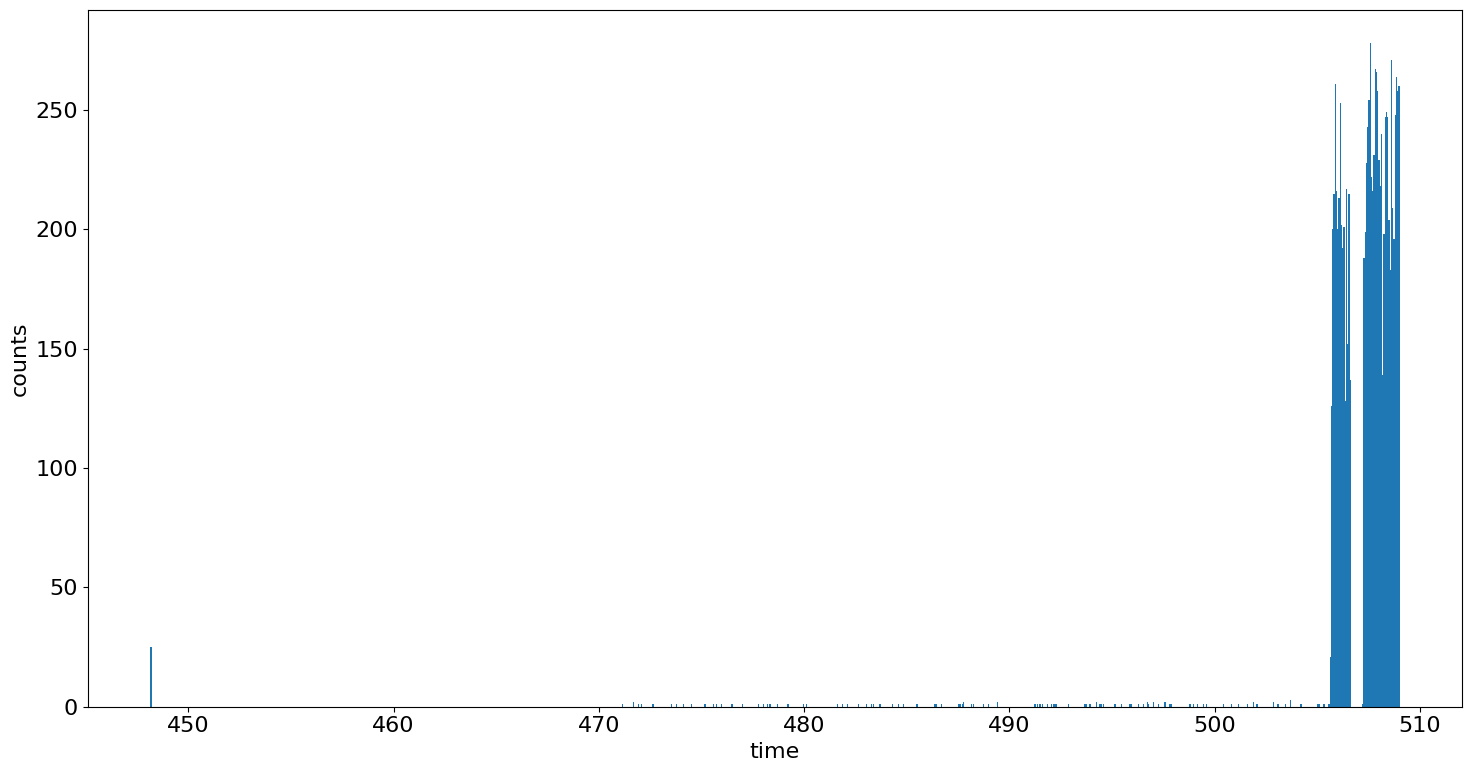

In [12]:
wr_time = ((times>>32) & 0xffffffff) + 1e-9*(4*(times & 0xffffffff))
#wr_time = wr_time[(wr_time > 75) & (wr_time < 85)]
print(wr_time)

fig, (ax1) = plt.subplots(1, 1)
ax1.hist(wr_time, bins=np.linspace(wr_time.min(), wr_time.max(), 1000))
ax1.set_xlabel("time")
ax1.set_ylabel("counts")
#ax1.set_yscale('log')

fig.tight_layout()


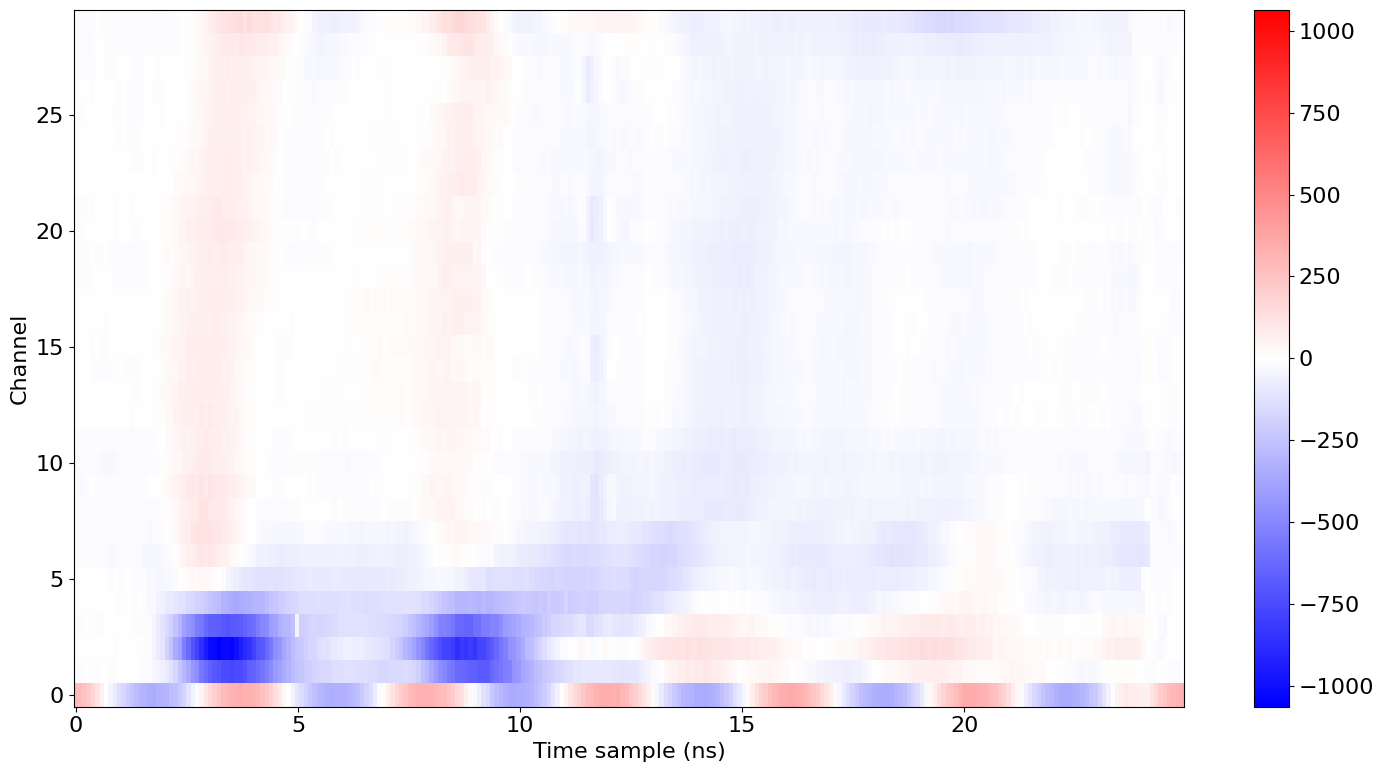

In [13]:
channels = np.array([5,4,3,2,1,0,11,10,9,8,7,6,17,16,15,14,13,12,23,22,21,20,19,18,29,28,27,26,25,24])
#channels = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])

event = 600

xdata = np.linspace(0, 255,256)*25/256
ydata = np.linspace(0, 29, 30)
zdata = data[event,channels,:]-averages[channels,:]

fig, (ax1) = plt.subplots(1, 1)
norm = matplotlib.colors.CenteredNorm()
#norm = matplotlib.colors.SymLogNorm(10)
cm = ax1.pcolormesh(xdata, ydata, zdata, norm=norm, cmap='bwr')
fig.colorbar(cm, ax = ax1)
ax1.set_xlabel("Time sample (ns)")
ax1.set_ylabel("Channel")


fig.tight_layout()


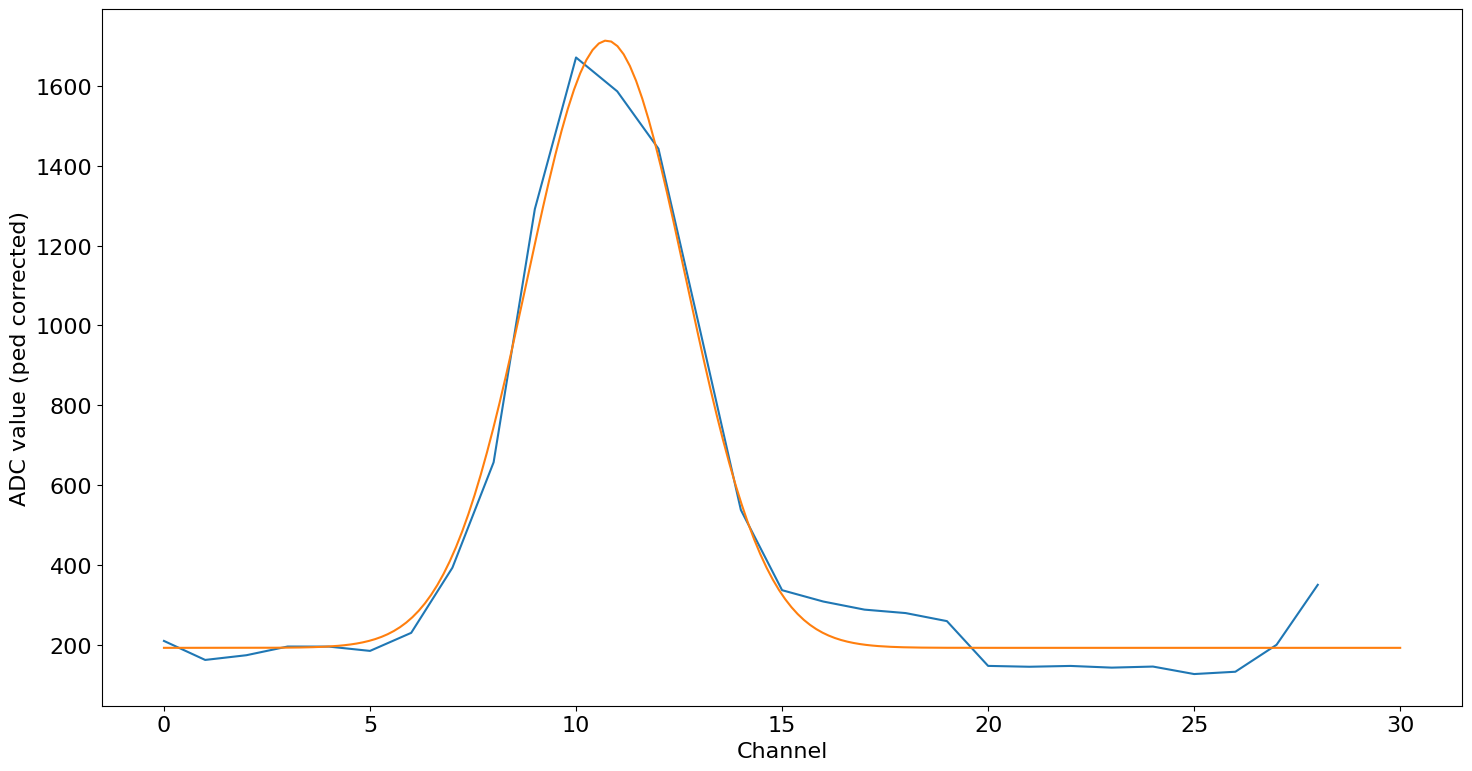

In [14]:
def Gauss(x, A, B, c, d):
    y = A*np.exp(-1*B*(x-c)**2) - d
    return y

np.set_printoptions(threshold=np.inf)

#channels = np.array([0,1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])
channels = np.array([4,3,2,1,0,11,10,9,8,7,6,17,16,15,14,13,12,23,22,21,20,19,18,29,28,27,26,25,24])

event = 665

xdata = np.linspace(0, 28,29)
ydata = data[event,:,:]-averages[:,:]

ydata = (-1)*ydata.min(axis=1)
ydata = ydata[channels]
#ydata[18] = (ydata[17]+ydata[19])/2
#ydata[26] = (ydata[25]+ydata[27])/2

popt = (ydata.max(), 2, ydata.argmax(), 0)
popt, pcov = scipy.optimize.curve_fit(Gauss, xdata, ydata, p0=popt)

xdraw = np.linspace(0, 30, 200)


fig, (ax1) = plt.subplots(1, 1)
#ax1.hist(centers, bins=np.linspace(0, 30, 30))
ax1.plot(xdata, ydata.flatten(), label="Pulse %i"%i)
ax1.plot(xdraw, Gauss(xdraw, *popt))
ax1.set_xlabel("Channel")
ax1.set_ylabel("ADC value (ped corrected)")


fig.tight_layout()


In [9]:
def fitfun(x, *p):
    A, mu, sigma, xi = p
    #return A*np.exp(-(x-mu)**2/(2.*sigma**2))
    #return A*landau.pdf(x=x,x_mpv=mu,xi=sigma)
    #return A*langauss.pdf(x=x,landau_x_mpv=mu,landau_xi=xi,gauss_sigma=sigma)
    return A*pylandau.langau_pdf(x, mu, xi, sigma)

def double_fitfun(x, *p):
    A1, mu1, sigma1, xi1, A2, mu2, sigma2, y0 = p
    #return A*np.exp(-(x-mu)**2/(2.*sigma**2))
    #return A*landau.pdf(x=x,x_mpv=mu,xi=sigma)
    #return A*langauss.pdf(x=x,landau_x_mpv=mu,landau_xi=xi,gauss_sigma=sigma)
    return fitfun(x, A1, mu1, sigma1, xi1) + fitfun(x, A2, mu2, sigma2, xi1) + y0
    
def Gauss(x, A, B, c, d):
    y = A*np.exp(-1*B*(x-c)**2) - d
    return y

def findCenters(data, averages):
    #channels = np.array([4,3,2,1,0,11,10,9,8,7,6,17,16,15,14,13,12,23,22,21,20,19,18,29,28,27,26,25,24])
    channels = np.array([4,3,2,1,0,11,10,9,8,7,6,17,16,15,14,13,12,23,22,21,20,19,18,29,28,27,26,25,24])

    centers = []
    centers2 = []
    centers3 = []
    amplitudes = []
    eventlist = []

    skipped = 0
    
    cfd_thresh = 0.4

    print(len(data))
    for event in range(len(data)):
    #event = 40
    
        if event % 1000 == 0:
            print("Event:", event)

        ydata = data[event,:,:]-averages[:,:]

        xdata_v = np.linspace(0, 28, 29)
        ydata_v = (-1)*ydata.min(axis=1)
        ydata_v = ydata_v[channels]
        #ydata_v[18] = (ydata_v[17]+ydata_v[19])/2
        #ydata_v[26] = (ydata_v[25]+ydata_v[27])/2

        #xdata_h = np.linspace(0, 255,256)
        deltax = np.array([256*4/259]+[256/259]*255)
        channel_h = ydata.min(axis=1).argmin()
        ydata_h = ydata[channel_h]
        
        trigOffset = 4
        
        cw_low = (((times_320[event]+trigOffset)%8)*32-16)%256
        cw_high = (((times_320[event]+trigOffset)%8)*32+24)%256

        ydata_h = np.roll(ydata_h, -cw_low)
        deltax = np.roll(deltax, -cw_low)
        xdata_h = np.cumsum(deltax)

        try:
            popt = (ydata_v.max(), 2, ydata_v.argmax(), 0)
            popt, pcov = scipy.optimize.curve_fit(Gauss, xdata_v, ydata_v, p0=popt)
            v_pos = popt[2]

            peaks2 = scipy.signal.find_peaks(-1*ydata_h, height=(-0.6)*ydata_h.min(), distance = 22)[0]
            peaks2 = peaks2[peaks2 > 38]
            if len(peaks2) != 2:
                continue
                
            peaks5 = []
            csl = []
            for xp1 in peaks2:
                xp1Cut = (xdata_h > (xp1-10)) & (xdata_h < (xp1+18))
                
                spl = splrep(xdata_h[xp1Cut], ydata_h[xp1Cut], k=3, s=10000)
                bs = BSpline(*spl)
                dbs = bs.derivative()
                xplot = np.linspace(xp1-15, xp1+15, 100)
                dcs = CubicSpline(xplot, dbs(xplot))
                extrema = dcs.solve(0)
                extrema = extrema[(extrema > (xp1-12)) & (extrema < (xp1+12))]
                if len(extrema) > 0:
                    extrema = extrema[bs(extrema).argsort()][0]
                else:
                    extrema = xp1 
                peaks5.append(extrema)
                
                #xdata_cut = xdata_h[xp1Cut]
                #ydata_cut = ydata_h[xp1Cut]
                #p0 = [-1000, xp1, 1., 1.]
                #coeff, var_matrix = curve_fit(fitfun, xdata_cut, ydata_cut, p0=p0)
                ##print(coeff)
                #peaks.append(coeff[1])
            peaks5 = np.array(peaks5)
            
            xp1Cut = (xdata_h > (peaks2[0]-20)) & (xdata_h < (peaks2[1]+20))
            xdata_cut = xdata_h[xp1Cut]
            ydata_cut = ydata_h[xp1Cut]
            param_bounds=([-1000000,0, 0.1, 0.1, -1000000, 0, 0.1, -100],[-10, 256, 10, 10, -10, 256, 10, 100])
            p0 = [-1000., 1.0*peaks2[0], 5., 5., -1000., 1.0*peaks2[1], 5., 0]
            coeff2, var_matrix2 = curve_fit(double_fitfun, xdata_cut, ydata_cut, p0=p0, bounds=param_bounds)
            
            peaks4 = np.array([coeff2[1], coeff2[5]])
            
            peaks3 = []

            funmin1 = fitfun(fmin(lambda x: fitfun(x, *coeff2[:4]), coeff2[1], disp=False), *coeff2[:4])
            #print("Fmin:", funmin1)
            lamfun1 = lambda x: fitfun(x, *coeff2[:4]) - funmin1*cfd_thresh
            peaks3.append(fsolve(lamfun1, [coeff2[1]-10]).min())

            funmin2 = fitfun(fmin(lambda x: fitfun(x, *(coeff2[4], coeff2[5], coeff2[6], coeff2[3])), coeff2[5], disp=False), 
                                                  *(coeff2[4], coeff2[5], coeff2[6], coeff2[3]))
            #print("Fmin:", funmin2)
            lamfun2 = lambda x: fitfun(x, *(coeff2[4], coeff2[5], coeff2[6], coeff2[3])) - funmin2*cfd_thresh
            peaks3.append(fsolve(lamfun2, [coeff2[5]-10]).min())

            peaks = np.array(peaks3)
            
            
            if len(peaks) != 2:
                continue
            peaks = peaks*25/256
            h_pos = peaks.max()-peaks.min()

            #peak_heights = bs(peaks)
            #if(peak_heights.max() < 0.5*peak_heights.min()):
            centers.append((h_pos, v_pos))
            
            peaks4 = peaks4*25/256
            centers2.append((peaks4.max()-peaks4.min(), v_pos))
            peaks5 = peaks5*25/256
            centers3.append((peaks5.max()-peaks5.min(), v_pos))
            amplitudes.append((funmin1, funmin2))
            eventlist.append(event)
        except Exception as ex:
            #raise
            skipped += 1

    print("Skipped: ", skipped)
    centers = np.array(centers)
    centers2 = np.array(centers2)
    centers3 = np.array(centers3)
    return centers, centers2, centers3, np.array(eventlist), np.array(amplitudes)

centers, centers2, centers3, eventlist, amplitudes = findCenters(data, averages)
print(len(centers))
#print(centers[:,0])
#ydata = (-1)*ydata[:,205]

#centers = centers[(centers[:,0] > 2) & (centers[:,0] < 7)]
#selection = centers[:,0] > 16
#centers[:,0][selection] = 25 - centers[:,0][selection]


10000
Event: 0


/tmp/ipykernel_424502/4189477590.py:16: RuntimeWarning: overflow encountered in exp
  y = A*np.exp(-1*B*(x-c)**2) - d
/tmp/ipykernel_424502/4189477590.py:16: RuntimeWarning: overflow encountered in multiply
  y = A*np.exp(-1*B*(x-c)**2) - d
/home/pastika/beamCounters/py/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/pastika/beamCounters/py/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:505: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/home/pastika/beamCounters/py/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterat

Event: 1000
Event: 2000
Event: 3000
Event: 4000
Event: 5000
Event: 6000
Event: 7000
Event: 8000
Event: 9000
Skipped:  14
5562


<class 'numpy.ndarray'>


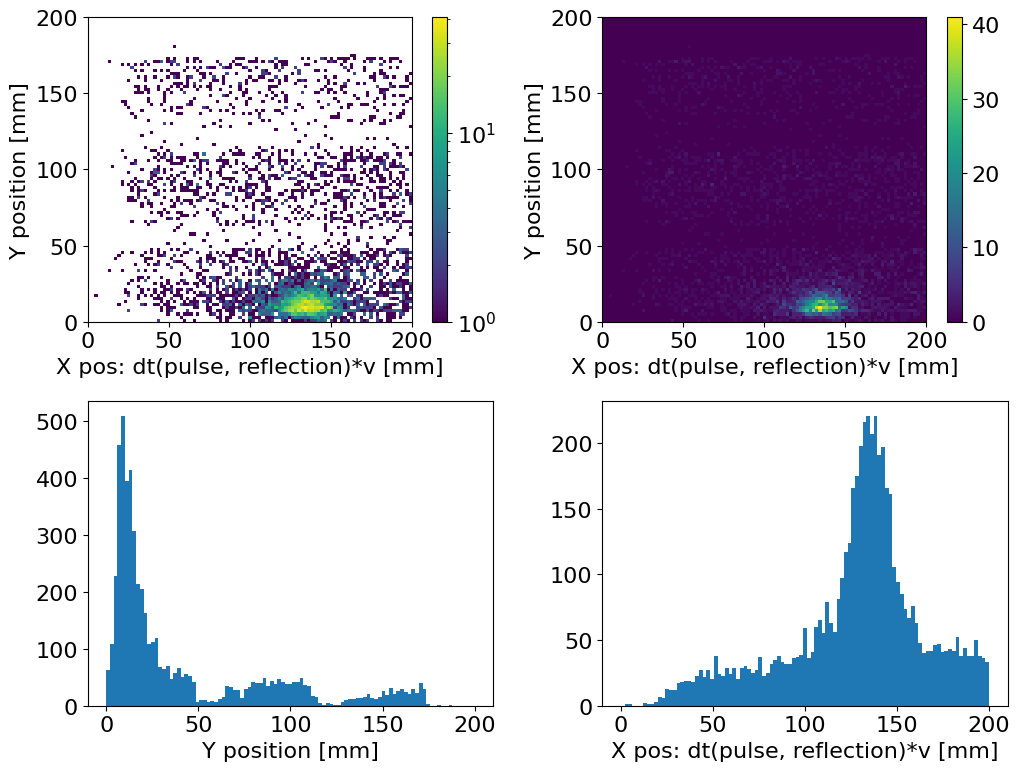

In [10]:
mm_per_ns = 72
offset_in_ns = 3.3
mm_per_strip = 6.6
print(type(centers))

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2)
fig.set_size_inches([10.5,8])
#ax1.hist(centers[:,0], bins=np.linspace(2, 8, 100))
#xbins = (np.linspace(3.5, 6.5, 26)-offset_in_ns)*mm_per_ns
#ybins = np.linspace(0, 30, 31)*mm_per_strip
#xbins = (np.linspace(3.5, 6.5, 100)-offset_in_ns)*mm_per_ns
#ybins = np.linspace(0, 30, 100)*mm_per_strip
xbins = np.linspace(0, 200, 100)
ybins = np.linspace(0, 200, 100)

cent = centers

ax3.hist(cent[:,1]*mm_per_strip, bins=ybins)
ax3.set_xlabel("Y position [mm]")

ax4.hist((cent[:,0]-offset_in_ns)*mm_per_ns, bins=xbins)
ax4.set_xlabel("X pos: dt(pulse, reflection)*v [mm]")

h = ax1.hist2d((cent[:,0]-offset_in_ns)*mm_per_ns,cent[:,1]*mm_per_strip, bins=(xbins, ybins), norm=matplotlib.colors.LogNorm())
ax1.set_xlabel("X pos: dt(pulse, reflection)*v [mm]")
ax1.set_ylabel("Y position [mm]")
fig.colorbar(h[3], ax=ax1)

h2 = ax2.hist2d((cent[:,0]-offset_in_ns)*mm_per_ns,cent[:,1]*mm_per_strip, bins=(xbins, ybins))#, norm=matplotlib.colors.LogNorm())
ax2.set_xlabel("X pos: dt(pulse, reflection)*v [mm]")
ax2.set_ylabel("Y position [mm]")
fig.colorbar(h2[3], ax=ax2)
fig.tight_layout()

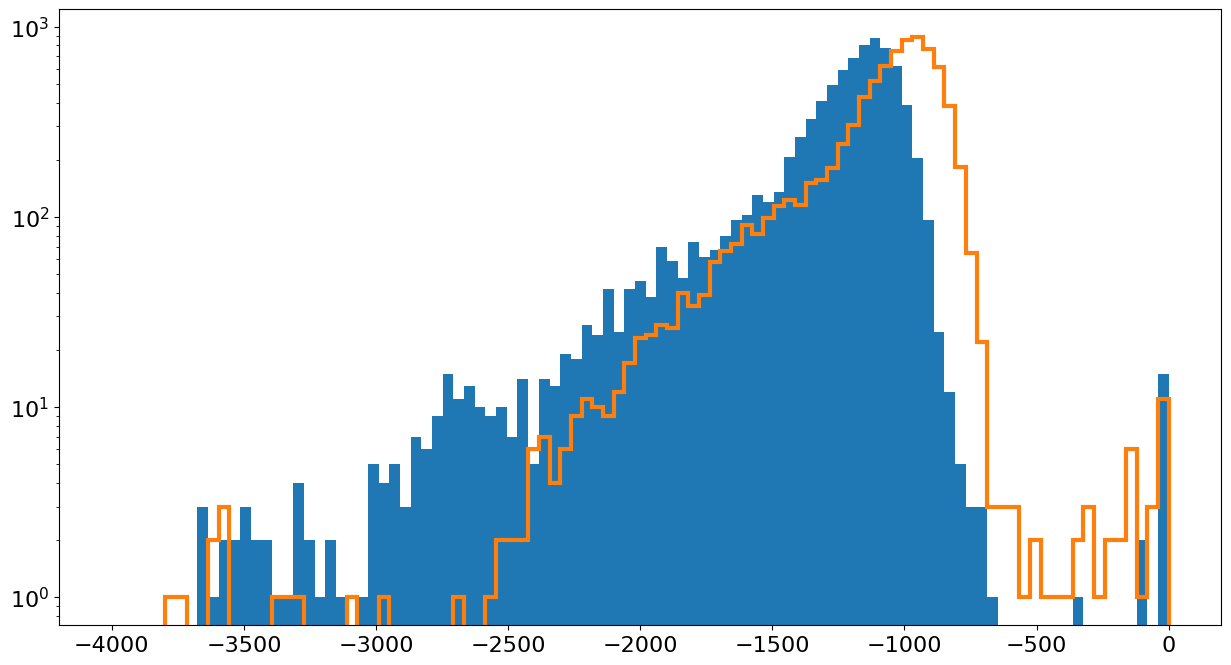

In [17]:
plt.hist(amplitudes[:,0], bins=np.linspace(-4000, 0, 100))
plt.hist(amplitudes[:,1], bins=np.linspace(-4000, 0, 100), histtype='step', linewidth=3)
plt.yscale('log')

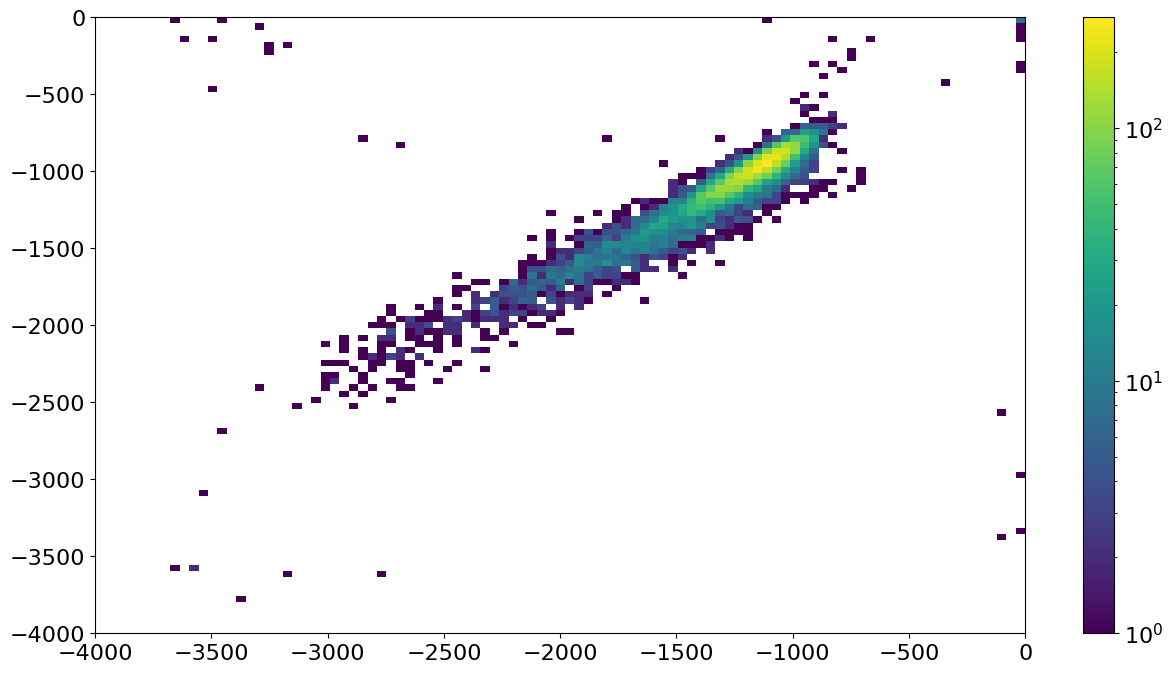

In [18]:
h = plt.hist2d(amplitudes[:,0].reshape([-1]), amplitudes[:,1].reshape([-1]), bins=np.linspace(-4000, 0, 100), norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3])
fig.tight_layout()

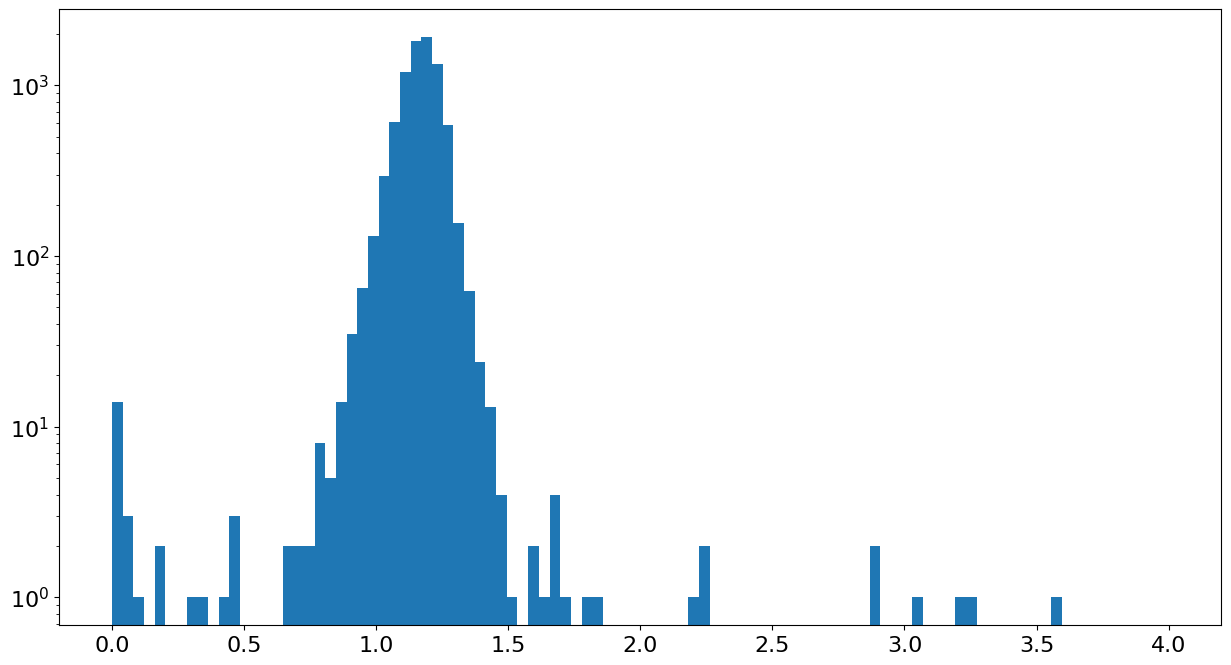

In [31]:
plt.hist(amplitudes[:,0].reshape([-1])/amplitudes[:,1].reshape([-1]), bins=np.linspace(0, 4, 100))
plt.yscale("log")

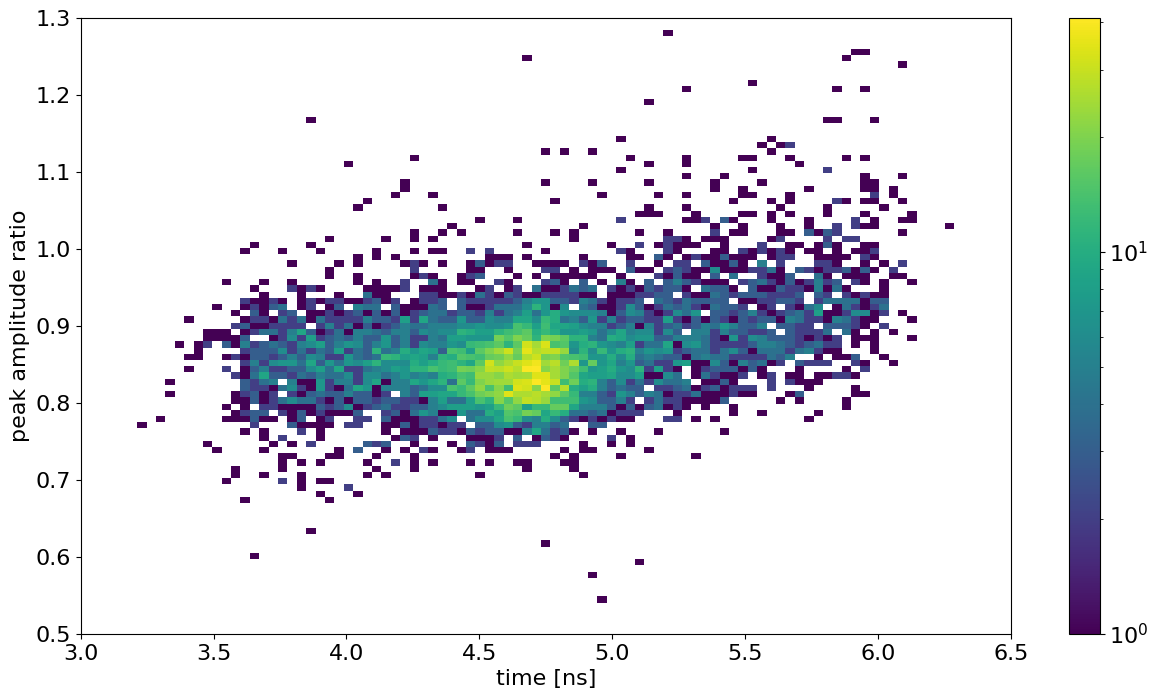

In [44]:
h = plt.hist2d(centers[:,0], amplitudes[:,1].reshape([-1])/amplitudes[:,0].reshape([-1]), bins=[np.linspace(3, 6.5, 100),np.linspace(0.5, 1.3, 100)], norm=matplotlib.colors.LogNorm())
plt.xlabel("time [ns]")
plt.ylabel("peak amplitude ratio")
fig.colorbar(h[3])
fig.tight_layout()

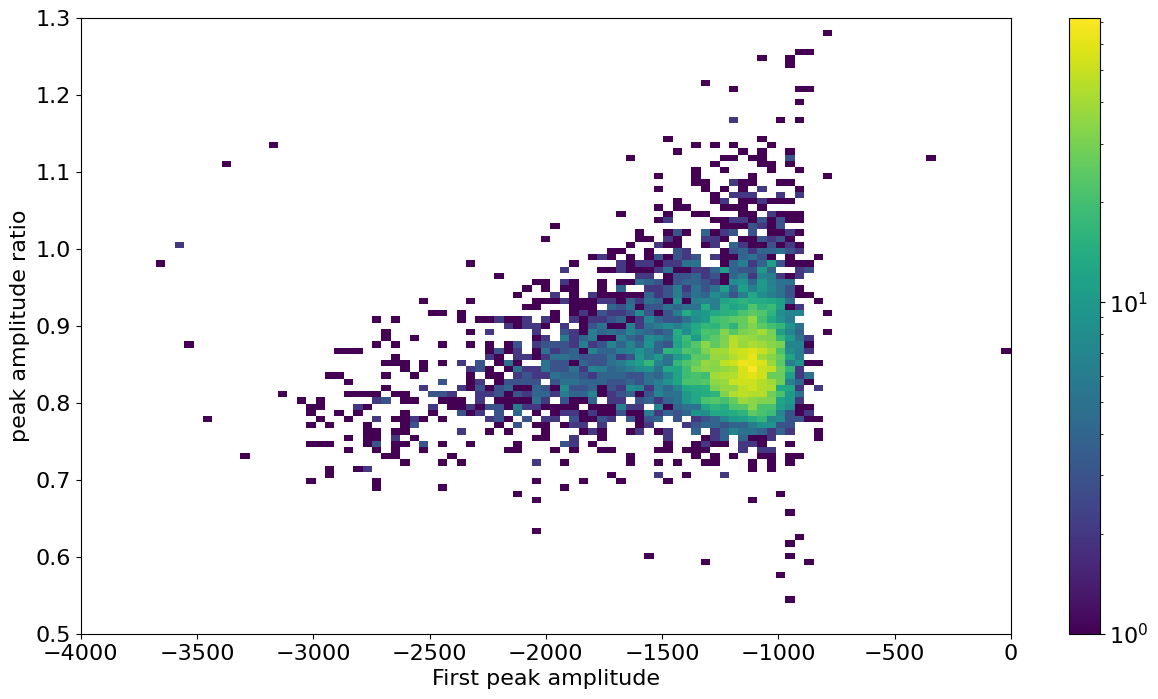

In [48]:
h = plt.hist2d(amplitudes[:,0].reshape([-1]), amplitudes[:,1].reshape([-1])/amplitudes[:,0].reshape([-1]), bins=[np.linspace(-4000, 0, 100),np.linspace(0.5, 1.3, 100)], norm=matplotlib.colors.LogNorm())
plt.xlabel("First peak amplitude")
plt.ylabel("peak amplitude ratio")
fig.colorbar(h[3])
fig.tight_layout()

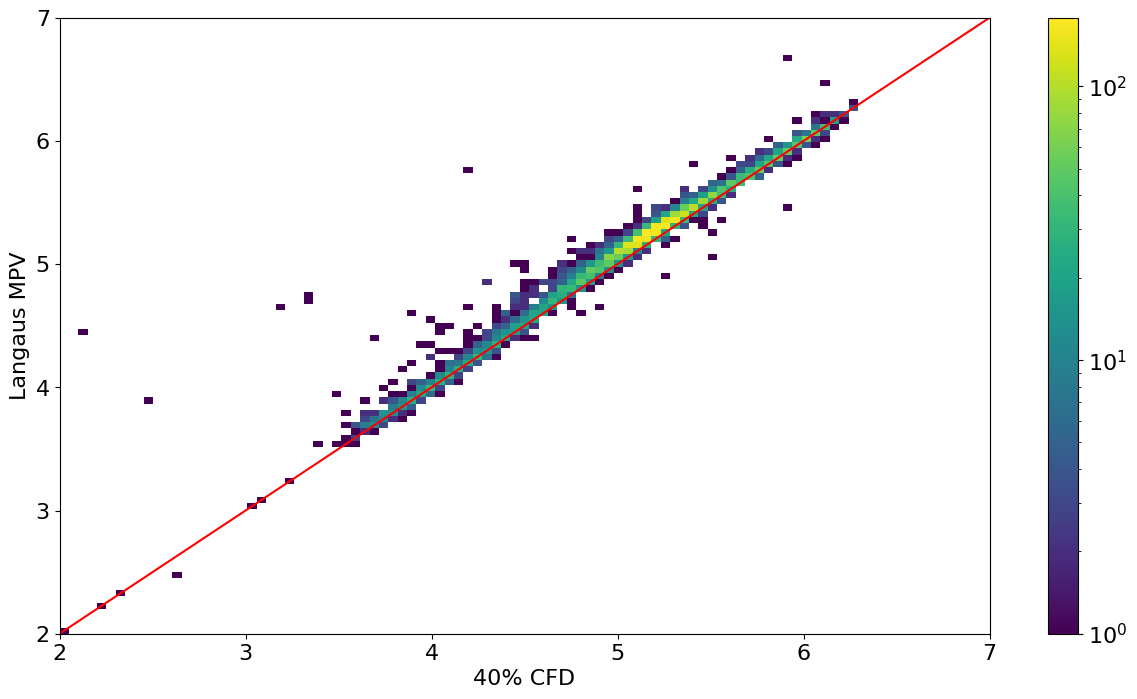

In [18]:
def linear(x, m, b):
    return m*x+b

h = plt.hist2d(centers[:,0], centers2[:,0], bins=np.linspace(2,7,100), norm=matplotlib.colors.LogNorm())
#plt.xlim(2.5, 7)
#plt.ylim(2.5, 7)
res = curve_fit(linear, centers[:,0], centers2[:,0], [1, 0])
x_display = np.linspace(centers[:,0].min(), centers[:,0].max(), 100)
plt.plot(x_display, x_display, color="red")
plt.xlabel("40% CFD")
plt.ylabel("Langaus MPV")
fig.colorbar(h[3])
fig.tight_layout()

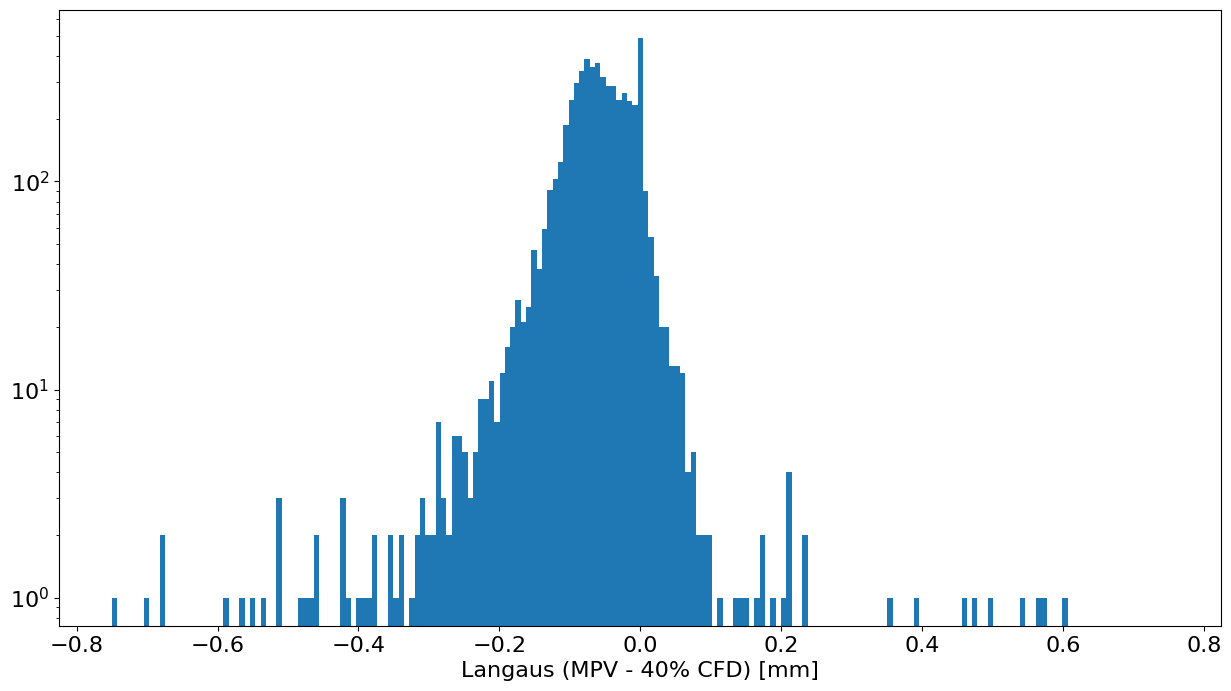

In [39]:
h = plt.hist(centers[:,0] - centers2[:,0], bins=np.linspace(-0.75, 0.75, 200))
plt.yscale("log")
#plt.xlim(2.5, 7)
#plt.ylim(2.5, 7)
plt.xlabel("Langaus (MPV - 40% CFD) [mm]")
#plt.ylabel("Langaus MPV")
fig.tight_layout()

In [160]:
skippedEvents = []

for event in range(len(data)):

    if event % 1000 == 0:
        print("Event:", event)

    ydata = data[event,:,:]-averages[:,:]

    channel_h = ydata.min(axis=1).argmin()
    ydata_h = ydata[channel_h]
    
    trigOffset = 4

    cw_low = (((times_320[event]+trigOffset)%8)*32-16)%256
    cw_high = (((times_320[event]+trigOffset)%8)*32+24)%256

    ydata_h = np.roll(ydata_h, -cw_low)

    peaks2 = scipy.signal.find_peaks(-1*ydata_h, height=(-0.6)*ydata_h.min(), distance = 22)[0]
    
    if len(peaks2) < 2 or (peaks2.min() < 38):
        skippedEvents.append(event)
        
print(skippedEvents)

Event: 0
Event: 1000
Event: 2000
Event: 3000
Event: 4000
Event: 5000
Event: 6000
Event: 7000
Event: 8000
Event: 9000
[0, 13, 17, 25, 26, 27, 32, 39, 41, 43, 46, 47, 48, 49, 50, 51, 56, 57, 60, 63, 65, 71, 77, 78, 84, 86, 88, 91, 92, 94, 101, 104, 106, 108, 109, 114, 117, 119, 121, 122, 123, 124, 125, 128, 129, 134, 138, 140, 142, 148, 160, 171, 173, 184, 188, 197, 201, 217, 226, 227, 228, 229, 230, 236, 239, 245, 246, 247, 248, 249, 263, 270, 292, 294, 299, 303, 304, 317, 324, 332, 333, 337, 342, 344, 371, 379, 382, 386, 397, 399, 408, 412, 417, 418, 432, 440, 441, 443, 446, 447, 451, 460, 465, 479, 482, 489, 502, 512, 522, 529, 530, 553, 574, 577, 591, 600, 601, 604, 611, 622, 627, 631, 632, 634, 636, 642, 643, 645, 651, 657, 661, 670, 672, 684, 688, 703, 721, 724, 737, 740, 749, 754, 761, 766, 771, 775, 783, 788, 793, 794, 807, 813, 820, 826, 831, 844, 846, 869, 873, 875, 877, 881, 888, 907, 908, 910, 922, 925, 927, 929, 932, 951, 954, 960, 961, 976, 978, 980, 1007, 1008, 1011, 1012,

In [275]:
eventlist[centers[:,0] > 10]

array([  36,  293,  779, 1077, 1991, 2039, 2275, 2430, 2579, 2724, 2927,
       3234, 3501, 3600, 4048, 4877, 4895, 5133, 5385, 5440, 5506, 5544,
       5704, 5869, 6345, 6975, 7014, 7118, 7597, 7962, 7998, 8278, 8484,
       8746, 9102, 9382, 9540])

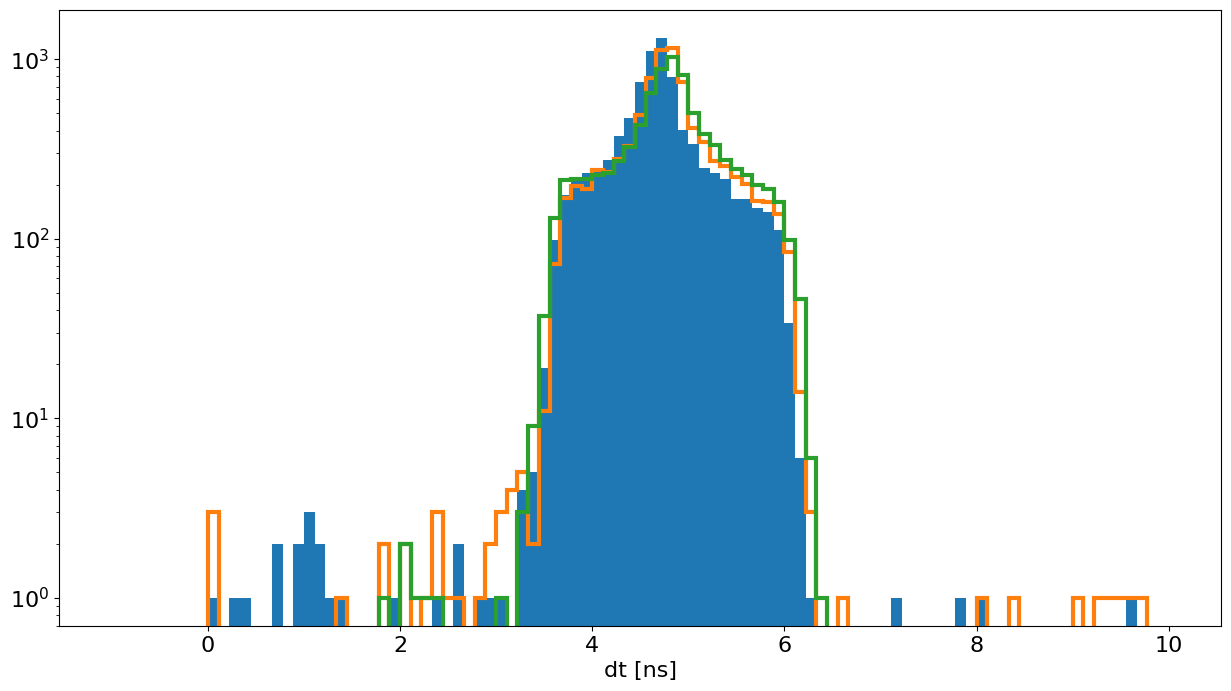

In [45]:
plt.hist(centers[:,0], bins=np.linspace(-1, 10, 100))
plt.hist(centers2[:,0], bins=np.linspace(-1, 10, 100), histtype='step', linewidth=3)
plt.hist(centers3[:,0], bins=np.linspace(-1, 10, 100), histtype='step', linewidth=3)
plt.xlabel("dt [ns]")
plt.yscale('log')

In [69]:
sine_chan = 0
channel = 1
#channel_pulse = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])
#channel_pulse = np.array([0,1,2,3,4,5])+3*6


def ffunc(x, A, offset, xi, sigma):
    return A*scipy.special.voigt_profile(x-offset, sigma, xi)
    #return A*langauss.pdf(x, offset, xi, sigma)
    #return A*(x - offset)**2 + y0


for event in range(0, 200):

    xdata = np.linspace(0, 255,256)
    #ydata = data[event,channel,:]-averages[:,channel]
    #ydata_raw = data[event,channel,:] - data[event,channel,:].mean()
    ydata_pulse = data[event,:,:]-averages[:,:]
    #ydata_pulse_raw = data[event,channel_pulse,:]# - data[event,channel,:].mean()

    channel_pulse = np.array([5,])
    channel_pulse = np.concatenate((channel_pulse, np.array([ydata_pulse.min(axis=1).argmin()])))
    ydata_pulse = ydata_pulse[channel_pulse]
    
    fig, (ax1) = plt.subplots(1, 1)
    
    peaks = scipy.signal.find_peaks(-1*ydata_pulse[channel], height=(-0.5)*ydata_pulse.min(), distance = 20)
    if len(peaks[0]) < 2:
        continue
    
    if abs(peaks[0][0] - peaks[0][1]) > 125:
        amin = peaks[0][1]
    else:
        amin = peaks[0][0]
    min = ydata_pulse[channel,amin]
    
    #popt = (-1000, amin[channel], 10, 10)
    #popt, pcov = scipy.optimize.curve_fit(ffunc, xdata[data_cut], ydata_pulse[channel,:][data_cut], p0=popt)
    
    peaks2 = scipy.signal.find_peaks(-1*ydata_pulse[channel,:], height=(-0.5)*ydata_pulse[channel,:].min(), distance = 20)[0]
    peaks = []
    csl = []
    for xp1 in peaks2:
        xp1Cut = (xdata > (xp1-15)) & (xdata < (xp1+15))
        spl = splrep(xdata[xp1Cut], ydata_pulse[channel,:][xp1Cut], k=3, s=10000)
        bs = BSpline(*spl)
        dbs = bs.derivative()
        xplot = np.linspace(xp1-15, xp1+15, 100)
        dcs = CubicSpline(xplot, dbs(xplot))
        extrema = dcs.solve(0)
        extrema = extrema[(extrema > (xp1-12)) & (extrema < (xp1+12))]
        if len(extrema) > 0:
            extrema = extrema[bs(extrema).argsort()][0]
        else:
            extrema = xp1 
        peaks.append(extrema)
    peaks = np.array(peaks)
    peaks = peaks#*25/256
            
    #data_cut = (xdata > amin-20) & (xdata < amin+20)
    #cs = CubicSpline(xdata[data_cut], ydata_pulse[channel,:][data_cut])
    #xcs = np.linspace(np.max((0,amin-19)), np.min((amin+19,256)), 500)
    #t = cs.solve(min * 0.1)
    #print("time: ", t)
    
    cw_low = (((times_320[event]+2+1)%8)*32-16)%256
    cw_high = (((times_320[event]+2+1)%8)*32+24)%256
    popt = (500.0, 0.0, 1.0/20, 0.0)
    popt2 = (500.0, 0.0, 1.0/20, 0.0)
    try:
        popt, pcov = scipy.optimize.curve_fit(sine, xdata[cw_high:cw_high+50], ydata_pulse[sine_chan,cw_high:cw_high+50], p0=popt)
        popt, pcov = scipy.optimize.curve_fit(sine, xdata[cw_high:], ydata_pulse[sine_chan,cw_high:], p0=popt)

        popt2, pcov = scipy.optimize.curve_fit(sine, xdata[cw_low-50:cw_low], ydata_pulse[sine_chan,cw_low-50:cw_low], p0=popt)
        popt2, pcov = scipy.optimize.curve_fit(sine, xdata[:cw_low], ydata_pulse[sine_chan,:cw_low], p0=popt)
    except:
        pass
    #print("period:",2*math.pi/popt[2])
    #print("phi:",popt[3])
    
    for i, d in enumerate(ydata_pulse):
        ax1.plot(xdata, d, label="Pulse %i"%i)
    ax1.axvline(cw_low)
    ax1.axvline(cw_high)
    for peak in peaks:
        ax1.axvline(peak, color="red")
    #ax1.plot(xcs, cs(xcs))
    if len(t) > 1 :
        ax1.axvline(t[0], color="orange")
    xsine1 = np.linspace(cw_low, 256, 100)
    xsine2 = np.linspace(0, cw_high, 100)
    ax1.plot(xsine1, sine(xsine1, *popt))
    ax1.plot(xsine2, sine(xsine2, *popt2))
    ax1.set_xlabel("Time sample")
    ax1.set_ylabel("ADC value (ped corrected)")
    
    fig.text(0.1, 0.94, "%i.%09i s"%((times[event]>>32) & 0xffffffff, 4*(times[event] & 0xffffffff)))

    fig.tight_layout()
    fig.savefig("testPlots/Pulse_ch2_%i.png"%event)
    plt.close('all')

Event: 1078
Trig window: 240 24
rough peaks [ 66.22393822 116.63320463]
coefficients [-1.95766350e+05  6.63942537e+01  4.04848546e+00  5.33979308e+00
 -1.96134912e+05  1.15991044e+02  5.23042265e+00  2.02853077e+01]
49.59679012618777
50.40926640926631
[ 66.22393822 116.63320463]
(66.39425370967966, 115.99104383586743)
49.59679012618777
Optimization terminated successfully.
         Current function value: -1111.968105
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: -1050.908055
         Iterations: 17
         Function evaluations: 34
[ 56.08758556 105.01283848]
Rough: 50.40926640926631
MPV: 49.59679012618777
CFD: 48.92525291337692


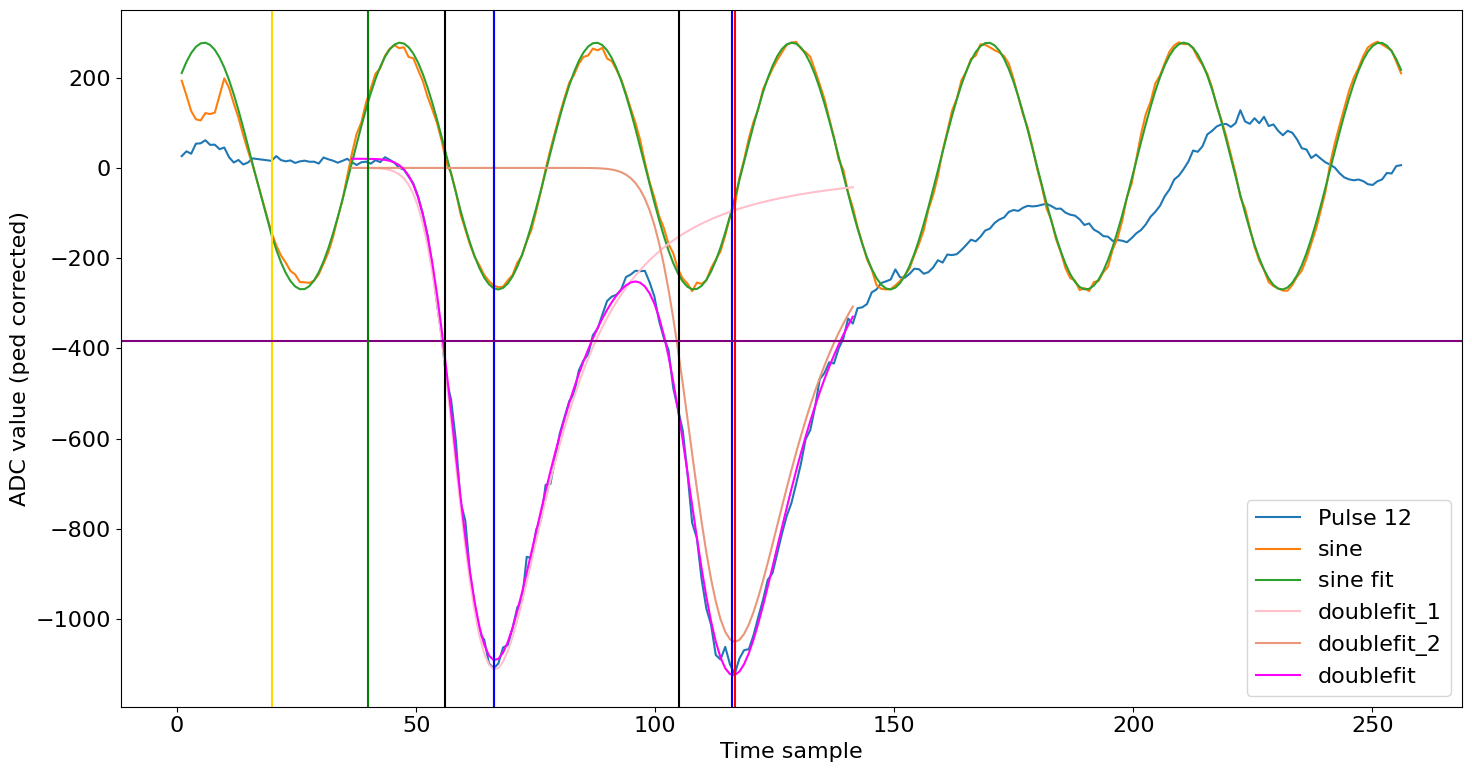

In [49]:
#%%timeit

event = 1078  #skippedEvents[125]
print("Event:", event)

def fitfun(x, *p):
    A, mu, sigma, xi = p
    #return A*np.exp(-(x-mu)**2/(2.*sigma**2))
    #return A*landau.pdf(x=x,x_mpv=mu,xi=sigma)
    #return A*langauss.pdf(x=x,landau_x_mpv=mu,landau_xi=xi,gauss_sigma=sigma)
    return A*pylandau.langau_pdf(x, mu, xi, sigma)

def double_fitfun(x, *p):
    A1, mu1, sigma1, xi1, A2, mu2, sigma2, y0 = p
    #return A*np.exp(-(x-mu)**2/(2.*sigma**2))
    #return A*landau.pdf(x=x,x_mpv=mu,xi=sigma)
    #return A*langauss.pdf(x=x,landau_x_mpv=mu,landau_xi=xi,gauss_sigma=sigma)
    return fitfun(x, A1, mu1, sigma1, xi1) + fitfun(x, A2, mu2, sigma2, xi1) + y0

def sine(x, A, B, omega, phi):
    return A * np.sin(2*math.pi*omega*x + phi) + B

#xdata = np.linspace(0, 255,256)
deltax = np.array([256*4/259]+[256/259]*255)
ydata = data[event,:,:]-averages[:,:]

channel = ydata.min(axis=1).argmin()

trigWindowOffset = 4

cw_low = (((times_320[event]+trigWindowOffset)%8)*32-16)%256
cw_high = (((times_320[event]+trigWindowOffset)%8)*32+24)%256

print("Trig window:", cw_low, cw_high)

ydata_sine = ydata[5]
ydata = ydata[channel]
ydata_sine = np.roll(ydata_sine, -cw_low)
ydata = np.roll(ydata, -cw_low)
deltax = np.roll(deltax, -cw_low)
xdata = np.cumsum(deltax)

peaks2 = scipy.signal.find_peaks(-ydata, height=(-0.6)*ydata.min(), distance = 22)[0]
peaks2 = xdata[peaks2]

peaks = []
csl = []
coefs = []
print("rough peaks", peaks2)
#for xp1 in peaks2:
#    #xp1 = peaks2.min()
#    xp1Cut = (xdata > (xp1-12)) & (xdata < (xp1+18))
#    xdata_cut = xdata[xp1Cut]
#    ydata_cut = ydata[xp1Cut]
#    
#    p0 = (-1000., 1.0*xp1, 5., 5.)
#
#    coeff, var_matrix = curve_fit(fitfun, xdata_cut, ydata_cut, p0=p0)
#    coeff = p0
#    
#    print("coefficients", coeff)
#    peaks.append(coeff[1])
#    coefs.extend(coeff)
#    csl.append((xdata_cut, fitfun(xdata_cut, *coeff)))

#peaks = np.array(peaks)
#peaks = peaks[(peaks > 0) & (peaks < 256)]
#peaks = peaks[np.argsort(bs(peaks))[:2]]

#sine fit
xp1cut_sine = xdata > 40
xdata_cut_sine = xdata[xp1cut_sine]
ydata_cut_sine = ydata_sine[xp1cut_sine]
p0_sine = [250, 0, 0.024, 0]
coeff_sine, var_matrix_sine = curve_fit(sine, xdata_cut_sine, ydata_cut_sine, p0=p0_sine)
#coeff_sine = p0_sine

#if(len(peaks2) > 2):
#    peaks2 = peaks2[peaks2 > 40]
peaks2 = peaks2[peaks2 > 38]

xp1Cut = (xdata > (peaks2.min()-30)) & (xdata < (peaks2.max()+25))
xdata_cut = xdata[xp1Cut]
ydata_cut = ydata[xp1Cut]
#p0 = coefs[:-1]
param_bounds=([-1000000,0, 0.1, 0.1, -1000000, 0, 0.1, -100],[-10, 256, 10, 10, -10, 256, 10, 100])
p0 = [-1000., 1.0*peaks2.min(), 5., 5., -1000., 1.0*peaks2.max(), 5., 0.]
coeff2, var_matrix2 = curve_fit(double_fitfun, xdata_cut, ydata_cut, p0=p0, bounds=param_bounds)
#coeff2 = p0
print("coefficients", coeff2)


peaks = np.array((coeff2[5],coeff2[1]))

try:
    print(peaks.max()-peaks.min())
    print(peaks2.max()-peaks2.min())
except:
    pass

print(peaks2)
#print(peaks)
print((coeff2[1], coeff2[5]))
print(coeff2[5] - coeff2[1])

peaks3 = []

cfd_frac = 0.4

funmin1 = fitfun(fmin(lambda x: fitfun(x, *coeff2[:4]), coeff2[1]), *coeff2[:4])
#print("Fmin:", funmin1)
lamfun1 = lambda x: fitfun(x, *coeff2[:4]) - funmin1*cfd_frac
peaks3.append(fsolve(lamfun1, [coeff2[1]-10]).min())

funmin2 = fitfun(fmin(lambda x: fitfun(x, *(coeff2[4], coeff2[5], coeff2[6], coeff2[3])), coeff2[5]), 
                                      *(coeff2[4], coeff2[5], coeff2[6], coeff2[3]))
#print("Fmin:", funmin2)
lamfun2 = lambda x: fitfun(x, *(coeff2[4], coeff2[5], coeff2[6], coeff2[3])) - funmin2*cfd_frac
peaks3.append(fsolve(lamfun2, [coeff2[5]-10]).min())

peaks3 = np.array(peaks3)
print(peaks3)
print("Rough:",  peaks2.max()-peaks2.min())
print("MPV:",  peaks.max()-peaks.min())
print("CFD:",  peaks3.max()-peaks3.min())

fig, (ax1) = plt.subplots(1, 1)
ax1.plot(xdata, ydata, label="Pulse %i"%channel)
#print(", ".join(["%f"%dat for dat in ydata]))
ax1.plot(xdata, ydata_sine, label="sine")
ax1.plot(xdata, sine(xdata, *coeff_sine), label="sine fit")
for i, (x, bs) in enumerate(csl):
    ax1.plot(x, bs, label="SingleFit_%i"%(i+1), color='orange')
ax1.plot(xdata_cut, fitfun(xdata_cut,*coeff2[:4]), label="doublefit_1", color='pink')
ax1.plot(xdata_cut, fitfun(xdata_cut,*(coeff2[4], coeff2[5], coeff2[6], coeff2[3])), label="doublefit_2", color='darksalmon')
ax1.plot(xdata_cut, double_fitfun(xdata_cut,*coeff2), label="doublefit", color='magenta')
#ax1.plot(xdata_cut, lamfun1(xdata_cut), label="doublefit", color='black')
#ax1.plot(xdata_cut, lamfun2(xdata_cut), label="doublefit", color='black')
#ax1.plot(xplot, dbs(xplot))
#ax1.plot(xplot, dcs(xplot))
#for x in peaks:
#    ax1.axvline(x, color="green")

for x in peaks2:
    ax1.axvline(x, color="red")
ax1.axvline(coeff2[1], color="blue")
ax1.axvline(coeff2[5], color="blue")
for x in peaks3:
    ax1.axvline(x, color="black")

ax1.axvline(xdata[256-cw_low], color="gold")

ax1.axhline(0x980-0xb00, color="purple")
    
ax1.set_xlabel("Time sample")
ax1.set_ylabel("ADC value (ped corrected)")

#ax1.axvline(cw_low, color="green")
#ax1.axvline(cw_high, color="green")
ax1.axvline(40, color="green")

ax1.legend()

fig.tight_layout()

In [48]:
(-8)%256

248

In [67]:
def test(*p):
    print (p)
    
test(1, "Test")

(1, 'Test')


In [40]:
_, times_1, data_1 = getDataRaw(["data/Raw_testData_ACC1_20230714_094355_b0.txt"])
_, times_2, data_2 = getDataRaw(["data/Raw_testData_ACC2_20230714_094355_b0.txt"])

data/Raw_testData_ACC1_20230714_094355_b0.txt
data/Raw_testData_ACC2_20230714_094355_b0.txt


[57.71514128 57.7152406  57.71537323 57.71550652 57.71562805 57.71571661
 57.7158268  57.71598283 57.71607073 57.71615925] 
 [57.71518593 57.71531854 57.71541706 57.7155181  57.71560554 57.71571746
 57.71582679 57.71598282 57.71607073 57.71617031] 
 [4.46439838e-05 7.79440111e-05 4.38360279e-05 1.15840126e-05
 2.25080154e-05 8.44012504e-07 3.99779765e-09 8.01810529e-09
 3.97272970e-09 1.10600055e-05]


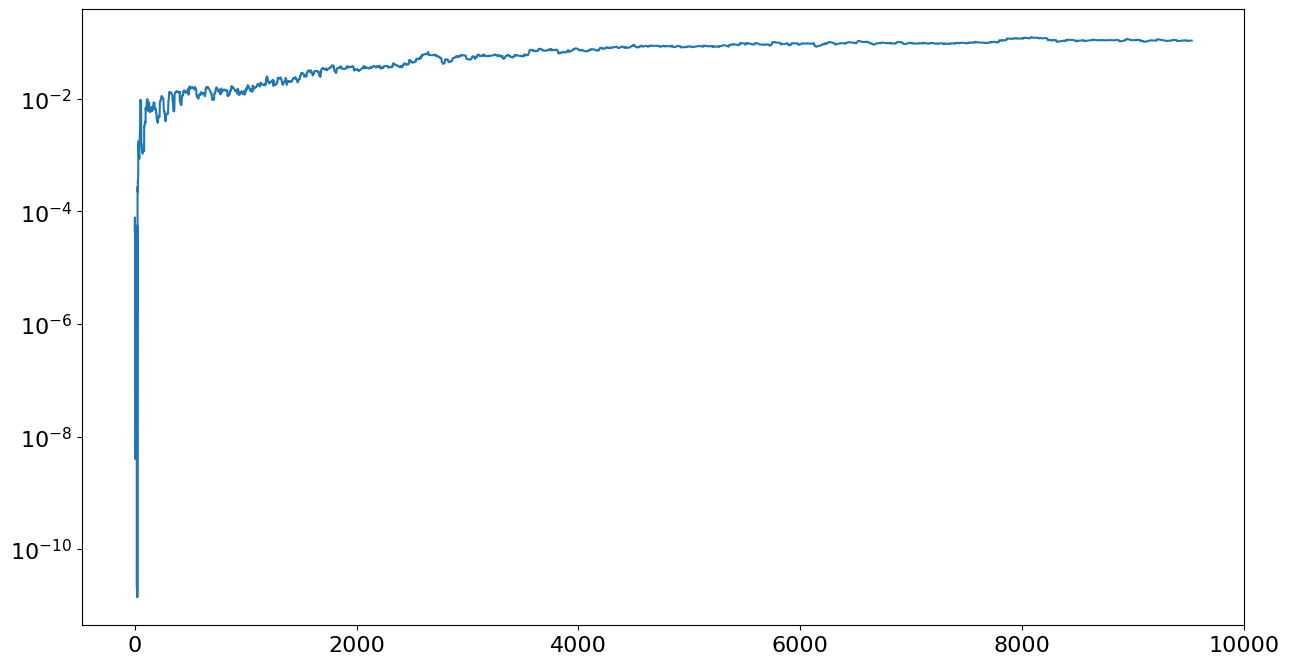

In [176]:
#def matchTimes(t1, t2):
#    while i < len(t1) and j < len(t2):
#        if abs(t1 - t2) < 0.000

times_parsed_1 = (times_1 >> 32) + (4e-9*(times_1&0xffffffff))
times_parsed_2 = (times_2 >> 32) + (4e-9*(times_2&0xffffffff))
times_parsed_1 -= math.floor(times_parsed_1.min())
times_parsed_2 -= math.floor(times_parsed_2.min())
timeRoughCut = (times_parsed_1 > 57.5) & (times_parsed_1 < 60.5) & \
               (times_parsed_2 > 57.5) & (times_parsed_2 < 60.5)
times_parsed_1 = times_parsed_1[timeRoughCut]
times_parsed_2 = times_parsed_2[timeRoughCut]
offset = 157
#plt.scatter(times_parsed_1[:-offset], times_parsed_2[offset:])
#plt.scatter(np.fmod(times_parsed_1,1), np.fmod(times_parsed_2,1))
plt.plot(np.abs(times_parsed_1[:-offset] - times_parsed_2[offset:]))
plt.yscale("log")
#plt.xlim([57.715, 57.72])
#plt.ylim([57.715, 57.72])
#times_parsed_2[150]
print(times_parsed_1[:-offset][:10], "\n", times_parsed_2[offset:][:10], "\n", np.abs(times_parsed_1[:-offset] - times_parsed_2[offset:])[:10])

/home/pastika/beamCounters/py/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:505: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


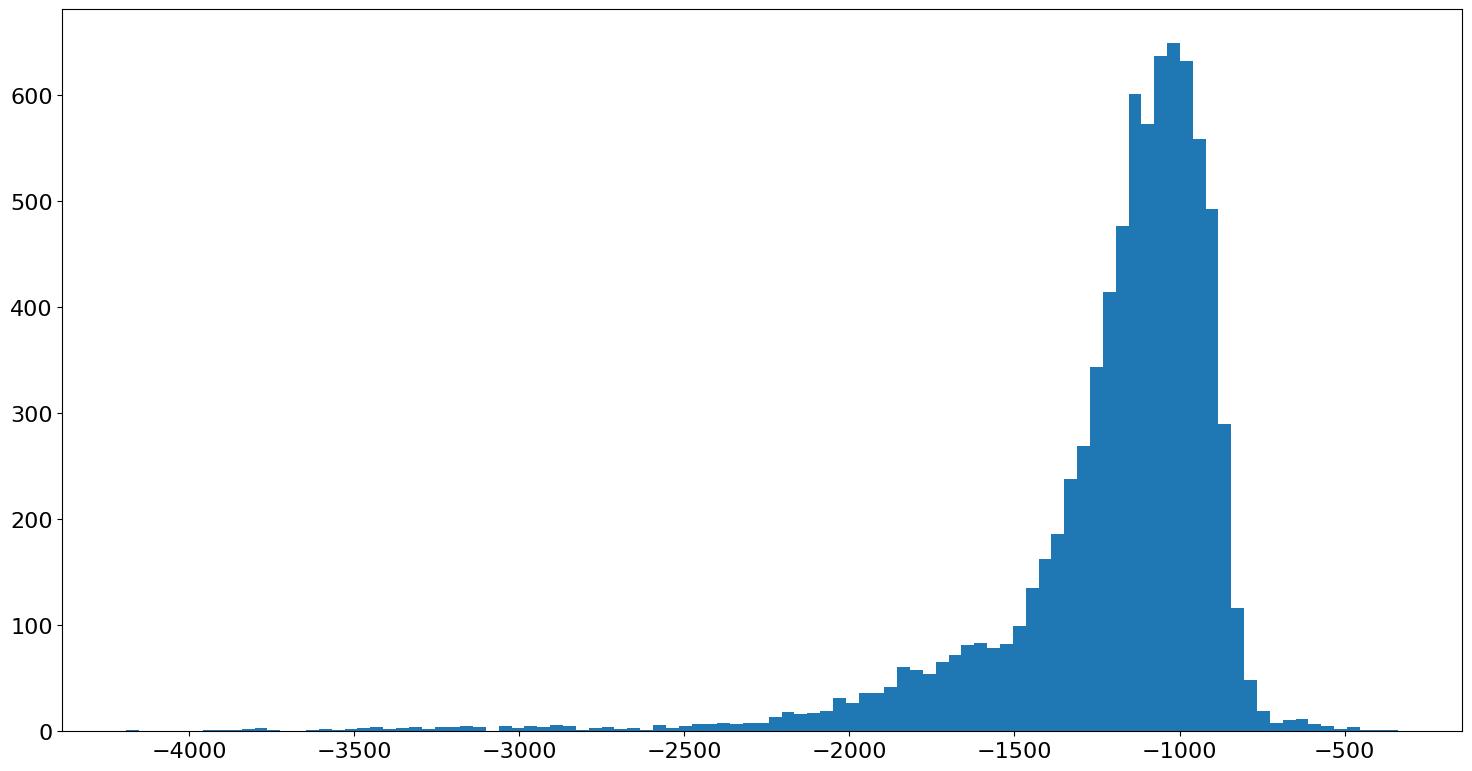

In [115]:
xdata = np.linspace(0, 255,256)

peakMax = []

for event in range(len(data)):
    ydata = data[event,:,:]-averages[:,:]

    channel = ydata.min(axis=1).argmin()

    ydata = ydata[channel]

    peaks2 = scipy.signal.find_peaks(-1*ydata, height=(-0.5)*ydata.min(), distance = 20)[0]

    peaks = []
    ypeaks = []
    csl = []
    #print(peaks2)
    try:
        for xp1 in peaks2:
            #xp1 = peaks2.min()
            xp1Cut = (xdata > (xp1-15)) & (xdata < (xp1+15))
            spl = splrep(xdata[xp1Cut], ydata[xp1Cut], k=3, s=10000)
            bs = BSpline(*spl)
            dbs = bs.derivative()
            #print(dcs.solve(0))
            xplot = np.linspace(xp1-15, xp1+15, 100)
            dcs = CubicSpline(xplot, dbs(xplot))
            extrema = dcs.solve(0)
            extrema = extrema[(extrema > (xp1-12)) & (extrema < (xp1+12))]
            #print("   extrema", extrema)
            #print("bs extrema", bs(extrema))
            extrema = extrema[bs(extrema).argsort()][0]
            #print("se extrema", extrema)
            peaks.append(extrema)
            ypeaks.append(float(bs(extrema)))
            csl.append((xdata[xp1Cut], bs))
        peaks = np.array(peaks)
        peaks = peaks[(peaks > 0) & (peaks < 256)]
    except:
        continue
    
    if len(peaks) != 2:
        continue
    
    ypeaks = np.array(ypeaks)
    ypeaks = ypeaks[peaks.argsort()]
    peaks.sort()
    if abs(peaks[1] - peaks[0]) > 150:
        peakMax.append(ypeaks[0])
    else:
        peakMax.append(ypeaks[1])

        
peakMax = np.array(peakMax)
peakMax = peakMax[peakMax > -5000]
plt.hist(peakMax, bins=np.linspace(peakMax.min(), peakMax.max(), 100))
plt.tight_layout()

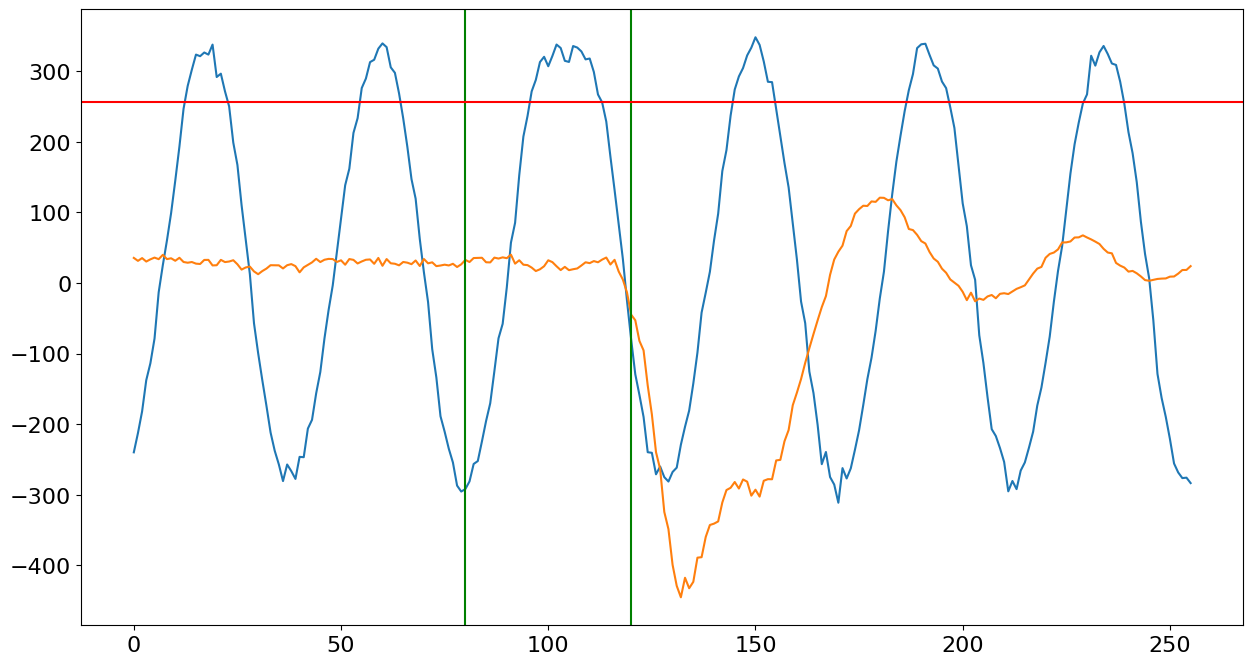

In [10]:
event = 15

cw_low = (((times_320[event]+0)%8)*32-16)%256
cw_high = (((times_320[event]+0)%8)*32+24)%256

ydata = data[event,:,:]-averages[:,:]
plt.plot(ydata[5])
plt.plot(ydata[11+18])
plt.axvline(cw_low, color="green")
plt.axvline(cw_high, color="green")
plt.axhline(0x100, color="red")
print("")

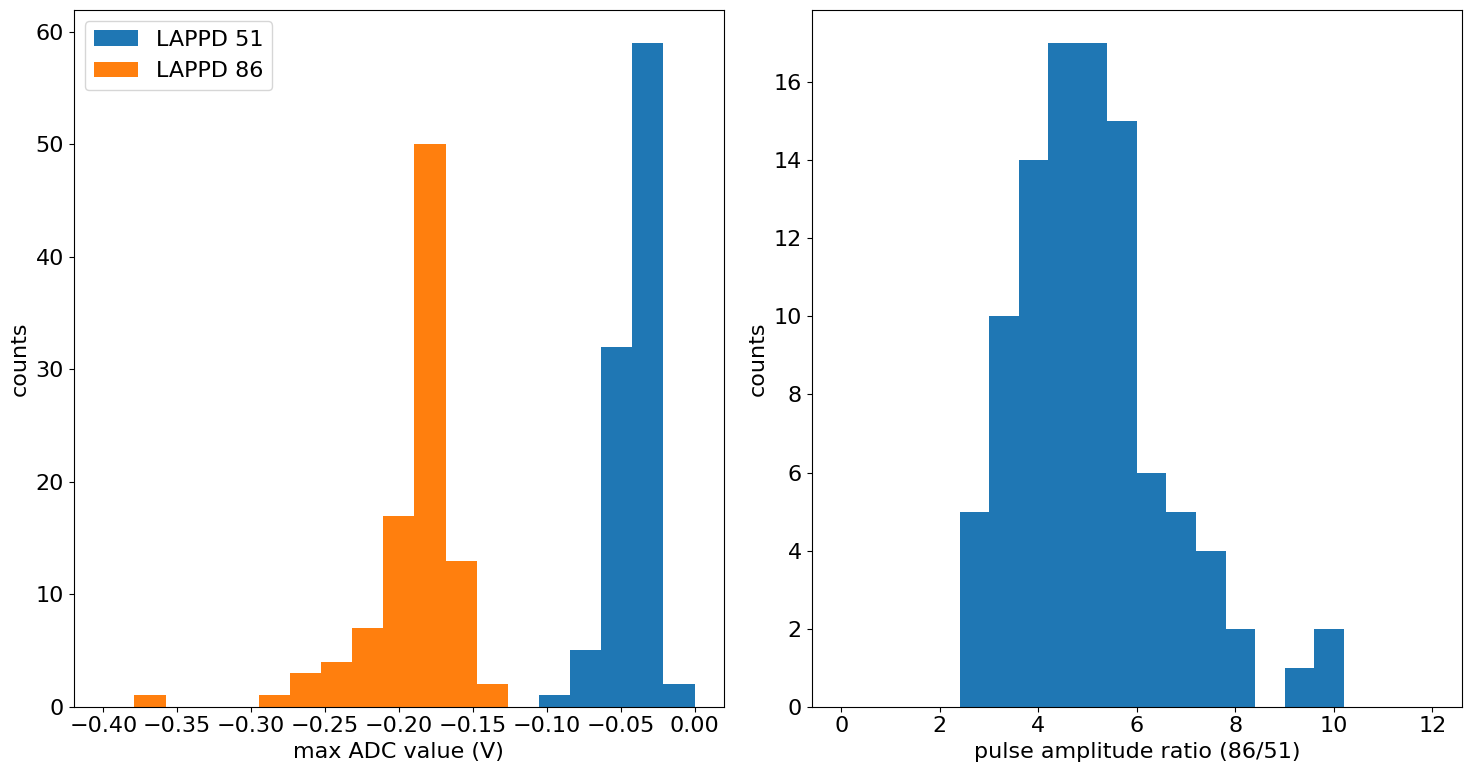

In [51]:
_, _, ped_data_1 = getDataRaw("data/Raw_testData_20230130_115948_b0.txt")
_, t1, data_1 = getDataRaw("data/Raw_testData_20230130_142710_b0.txt")

_, _, ped_data_2 = getDataRaw("data/Raw_testData_20230130_115948_b1.txt")
_, t2, data_2 = getDataRaw("data/Raw_testData_20230130_142710_b1.txt")

channels = np.array([4,3,2,1,0,11,10,9,8,7,6,17,16,15,14,13,12,23,22,21,20,19,18,29,28,27,26,25,24])

averages_1 = ped_data_1.mean(0)
averages_2 = ped_data_2.mean(0)

#xdata = np.linspace(0, 255,256)
ydata_1 = data_1[:,chaannels,:]-averages_1[channels,:]
ydata_2 = data_2[:,channels,:]-averages_2[channels,:]

ydata_1 = ydata_1.min(axis=1).min(axis=1)
ydata_2 = ydata_2.min(axis=1).min(axis=1)

ydata_1 = ydata_1*1.2/4096
ydata_2 = ydata_2*1.2/4096

bins = np.linspace(-0.4, 0, 20)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(ydata_1, bins=bins, label="LAPPD 51")
ax1.hist(ydata_2, bins=bins, label="LAPPD 86")
ax1.legend()

ax2.hist(ydata_2[:-1]/ydata_1, bins=np.linspace(0, 12, 21))

ax1.set_xlabel("max ADC value (V)")
ax1.set_ylabel("counts")
#ax1.set_title("max pulse amplitude")

ax2.set_xlabel("pulse amplitude ratio (86/51)")
ax2.set_ylabel("counts")
#ax2.set_title("")

fig.tight_layout()
fig.savefig("amplitude_ratio.png")

In [95]:
#STOP EDITING THIS ONE!!!!!
channel = 1
channel_pulse = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])
channel_pulse = np.array([0,1,2,3,4,5])+3*6

def ffunc(x, A, offset, xi, sigma):
    #return A*scipy.special.voigt_profile(x-offset, sigma, gamma)
    return A*langauss.pdf(x, offset, xi, sigma)
    #return A*(x - offset)**2 + y0


for event in range(10):

    xdata = np.linspace(0, 255,256)
    #ydata = data[event,channel,:]-averages[:,channel]
    #ydata_raw = data[event,channel,:] - data[event,channel,:].mean()
    ydata_pulse = data[event,channel_pulse,:]-averages[channel_pulse,:]
    #ydata_pulse_raw = data[event,channel_pulse,:]# - data[event,channel,:].mean()


    fig, (ax1) = plt.subplots(1, 1)
    
    amin = ydata_pulse.argmin(axis=1)
    min = ydata_pulse.min(axis=1)
    
    #popt = (-1000, amin[1], 10, 10)
    #popt, pcov = scipy.optimize.curve_fit(ffunc, xdata[(xdata > amin[1]-20) & (xdata < amin[1]+20)], ydata_pulse[1,:][(xdata > amin[1]-20) & (xdata < amin[1]+20)], p0=popt)
    
    
    
    for i, d in enumerate(ydata_pulse):
        ax1.plot(xdata, d, label="Pulse %i"%i)
    ax1.axvline((((times_320[event]+4+1)%8)*32+24)%256)
    ax1.axvline((((times_320[event]+4+1)%8)*32-16+256)%256)
    #ax1.axvline((popt[1]+256-56)%256, color="red")
    #ax1.axvline((popt[1]+256-48)%256, color="red")
    #ax1.axvline((amin[1])%256, color="orange")
    #ax1.axvline(popt[1], color="green")
    #plt.plot(xdata[(xdata > amin[1]-20) & (xdata < amin[1]+20)], ffunc(xdata[(xdata > amin[1]-20) & (xdata < amin[1]+20)], *popt))
    ax1.set_xlabel("Time sample")
    ax1.set_ylabel("ADC value (ped corrected)")
    #for i, d in enumerate(ydata_pulse_raw):
    #    ax2.plot(xdata, d, label="Pulse %i"%i)
    #ax2.set_xlabel("Time sample")
    #ax2.set_ylabel("ADC value (raw)")
    
    fig.text(0.1, 0.94, "%i.%09i s"%((times[event]>>32) & 0xffffffff, 4*(times[event] & 0xffffffff)))

    fig.tight_layout()
    fig.savefig("testPlots/Pulse_%i.png"%event)
    plt.close(fig)

(100, 30, 256) (30, 256)


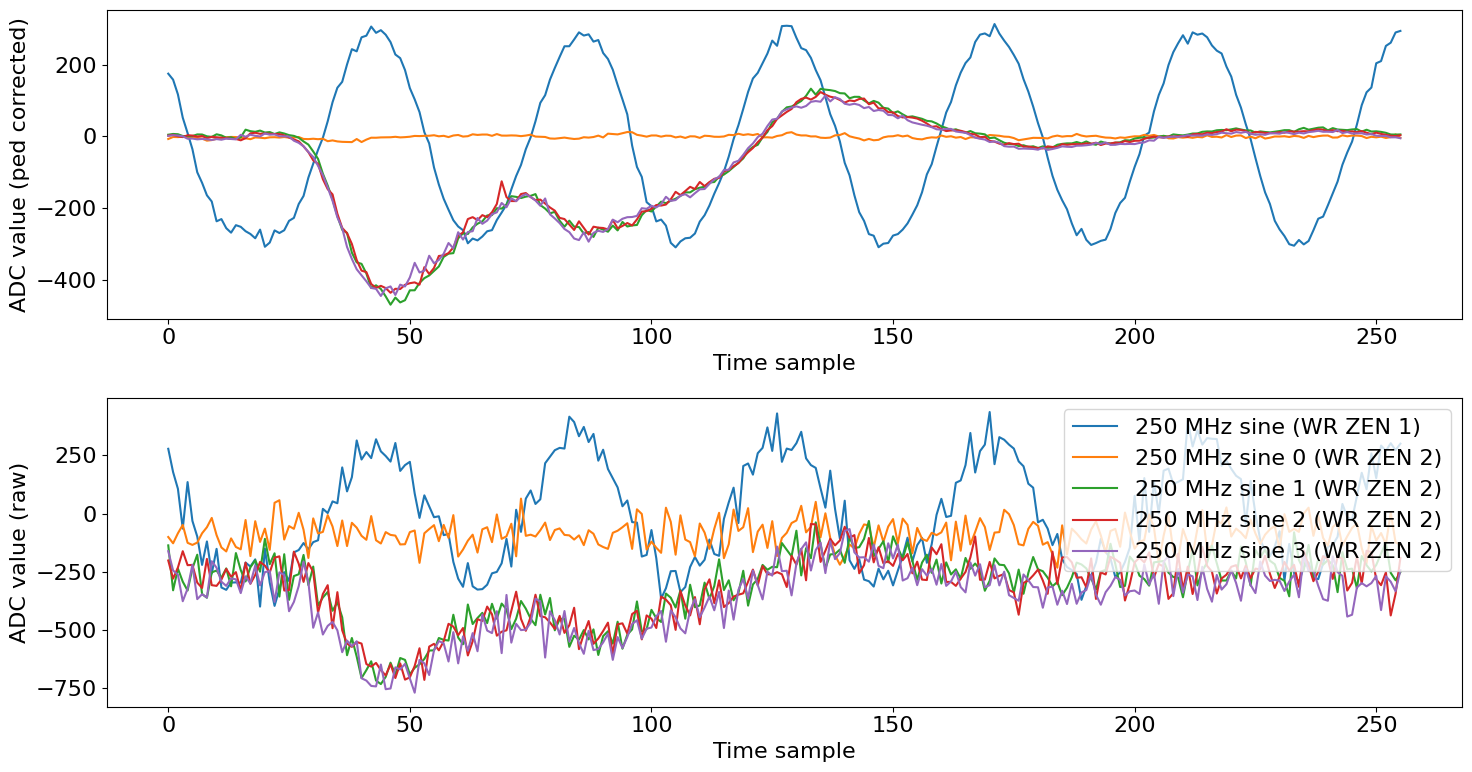

In [21]:
channel = 5
channel_pulse = np.array([11,17,23,29])
event = 9

xdata = np.linspace(0, 255,256)
print(data.shape, averages.shape)
ydata = data[event,channel,:]-averages[channel,:]
ydata_raw = data[event,channel,:] - data[event,channel,:].mean()
ydata_pulse = data[event,channel_pulse,:]-averages[channel_pulse,:]
ydata_pulse_raw = data[event,channel_pulse,:] - data[event,channel,:].mean()

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(xdata, ydata, label="250 MHz sine (WR ZEN 1)")
for i, d in enumerate(ydata_pulse):
    ax1.plot(xdata, d, label="250 MHz sine %i (WR ZEN 2)"%i)
#ax1.legend(loc="lower right")
ax1.set_xlabel("Time sample")
ax1.set_ylabel("ADC value (ped corrected)")

ax2.plot(xdata, ydata_raw, label="250 MHz sine (WR ZEN 1)")
for i, d in enumerate(ydata_pulse_raw):
    ax2.plot(xdata, d, label="250 MHz sine %i (WR ZEN 2)"%i)
ax2.legend(loc="upper right")
ax2.set_xlabel("Time sample")
ax2.set_ylabel("ADC value (raw)")

fig.tight_layout()

In [7]:
nzcdata = data-averages
channel = 5
x1 = 0
x2 = x1+2
y1 = nzcdata[:,channel, x1]
y2 = nzcdata[:,channel, x2]
intercept = x1-(x2-x1)/(y2-y1)*y1
nzc = np.count_nonzero(intercept > x1 & (intercept < x1+1))
print(nzc)
print(4000*nzc/(2*100000))
print(timeOffsets[0][1]*1e12)

49527
990.54


NameError: name 'timeOffsets' is not defined

In [273]:
timeOffsets = []


for ichan in [5, 11, 17, 23, 29]:
    offsets = []
    for iCap in range(256):
        
        cap1 = iCap
        cap2 = (iCap+1)%256
        channel = ichan

        ydata = data[:1000]-averages
        tdata = times_320[:1000]
        #ydata = linDat

        upper = ((((tdata+4+1)%8)*32+16+8)%256)
        lower = ((((tdata+4+1)%8)*32-24+256)%256)
        ugtl = upper > lower

        ydata = ydata[ugtl & (np.logical_not((cap1 >= lower) & (cap2 <= upper))) 
                      | ((cap1 == 255) & ((lower < 204) & (upper < 204)))]


        x = ydata[:,channel,cap2] + ydata[:,channel,cap1]
        y = ydata[:,channel,cap1] - ydata[:,channel,cap2]

        xmin = x.min()
        xmax = x.max()
        y_fit = y[(x > xmax*0.65) | (x < xmin*0.65)]
        x_fit = x[(x > xmax*0.65) | (x < xmin*0.65)]
        #y = y[(x > 4) | (x < 2.3)]
        #x = x[(x > 4) | (x < 2.3)]

        # Formulate and solve the least squares problem ||Ax - b ||^2
        A = np.column_stack([x_fit**2, x_fit * y_fit, y_fit**2, x_fit, y_fit])
        b = np.ones_like(x_fit)
        fit = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()
        #print(fit)

        try:
            a = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]+math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
            #print("a = %f"%a)
            b = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]-math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
            #print("b = %f"%b)

            dtij = math.atan(b/a)/(math.pi*250000000.0)
            #print("dtij = %f ps"%(dtij*1e12))
            offsets.append(dtij)
        except:
            offsets.append(100.0e-12)

        #plt.clf()
        #plt.scatter(x, y)

        # Plot the least squares ellipse
        x_coord = np.linspace(1.05*x.min(),1.05*x.max(),300)
        y_coord = np.linspace(1.05*y.min(),1.05*y.max(),300)
        X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
        Z_coord = fit[0] * X_coord ** 2 + fit[1] * X_coord * Y_coord + fit[2] * Y_coord**2 + fit[3] * X_coord + fit[4] * Y_coord
        #plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)
        #plt.savefig("Ellipse_chan_%i_cap_%i.png"%(ichan, cap1))

    timeOffsets.append(offsets)
    #plt.plot(ydata[0,:,5])

timeOffsets = np.array(timeOffsets)

In [341]:
timeOffsets2 = []


for ichan in [5, 11, 17, 23, 29]:
    offsets = []
    for iCap in range(256):

        cap1 = iCap
        cap2 = (iCap+1)%256
        channel = ichan

        ydata = data-averages
        #ydata = linDat

        upper = ((((times_320+4+1)%8)*32+16+8)%256)
        lower = ((((times_320+4+1)%8)*32-24+256)%256)
        ugtl = upper > lower

        ydata = ydata[ugtl & (np.logical_not((cap1 >= lower) & (cap2 <= upper))) 
                      | ((cap1 == 255) & ((lower < 204) & (upper < 204)))]


        x = ydata[:,channel,cap2] + ydata[:,channel,cap1]
        y = ydata[:,channel,cap1] - ydata[:,channel,cap2]

        #y = y[(x > 1200) | (x < -1200)]
        #x = x[(x > 1200) | (x < -1200)]
        #y = y[(x > 4) | (x < 2.3)]
        #x = x[(x > 4) | (x < 2.3)]

        # Formulate and solve the least squares problem ||Ax - b ||^2
        A = np.column_stack([x**2, x * y, y**2, x, y])
        b = np.ones_like(x)
        fit = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()
        #print(fit)

        try:
            a = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]+math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
            #print("a = %f"%a)
            b = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]-math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
            #print("b = %f"%b)

            dtij = math.atan(b/a)/(math.pi*250000000.0)
            #print("dtij = %f ps"%(dtij*1e12))
            offsets.append(dtij)
        except:
            offsets.append(100.0e-12)

    timeOffsets2.append(offsets)
    #plt.plot(ydata[0,:,5])
    #plt.scatter(x, y)

    # Plot the least squares ellipse
    x_coord = np.linspace(1.05*x.min(),1.05*x.max(),300)
    y_coord = np.linspace(1.05*y.min(),1.05*y.max(),300)
    X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
    Z_coord = fit[0] * X_coord ** 2 + fit[1] * X_coord * Y_coord + fit[2] * Y_coord**2 + fit[3] * X_coord + fit[4] * Y_coord
    #plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

timeOffsets2 = np.array(timeOffsets2)

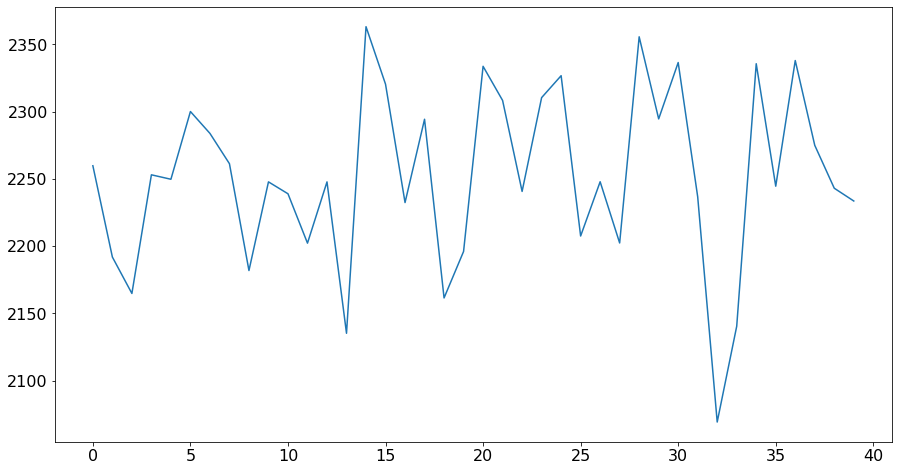

In [42]:
plt.plot(averages[11,:40])

[4.1882627]
a = 676.403050
b = 52.724171
dtij = 99.046026 ps
angle = 0.009042



Text(0, 0.5, 'Vi - Vj')

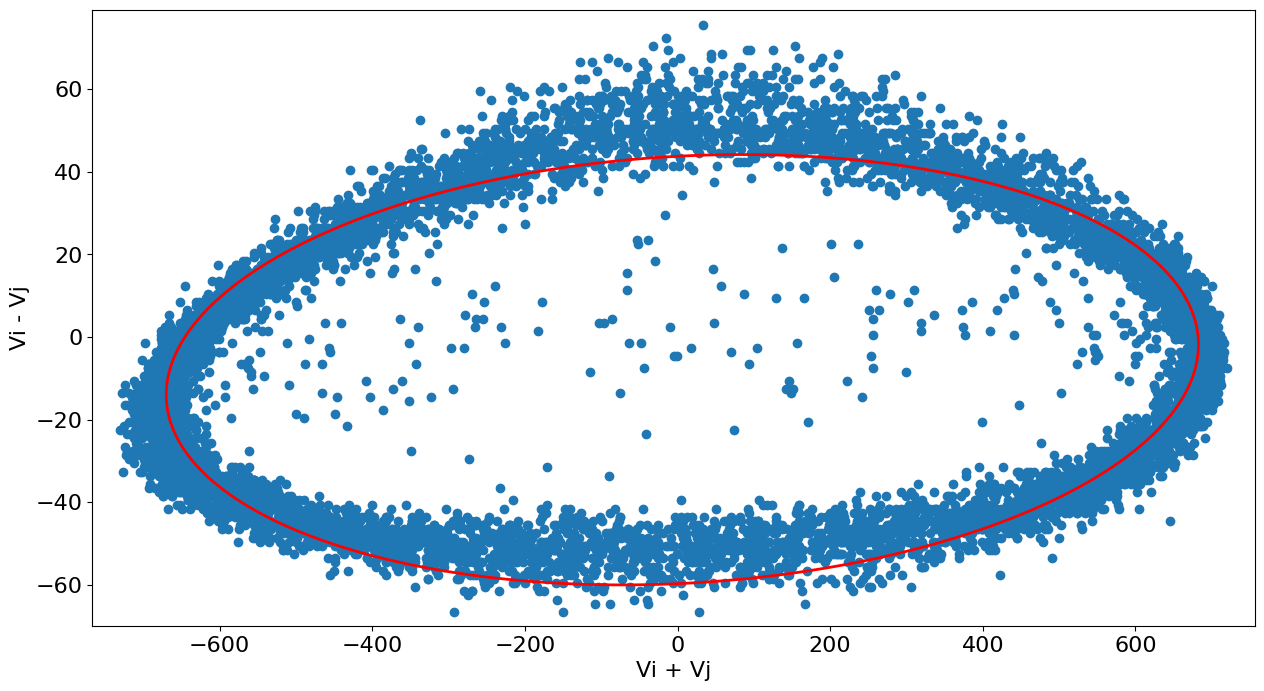

In [13]:
ydata = data-averages
#ydata = linDat

cap = 2
cap1 = cap
cap2 = (cap+1)%256
channel = 5

#upper = ((((times_320+4+1)%8)*32+16+8)%256)
#lower = ((((times_320+4+1)%8)*32-24+256)%256)
lower = (((times_320+3+1)%8)*32-16)%256
upper = (((times_320+3+1)%8)*32+24)%256
ugtl = upper > lower

ydata = ydata[ugtl & (np.logical_not((cap1 >= lower) & (cap2 <= upper))) 
                  | ((cap1 == 255) & ((lower < 204) & (upper < 204)))]
    

#ydata = ydata - ydata.mean(axis=0)
    
x = ydata[:,channel,cap2] + ydata[:,channel,cap1]
y = ydata[:,channel,cap1] - ydata[:,channel,cap2]
#x = ydata[:,cap2,11] + ydata[:,cap1,17]
#y = ydata[:,cap1,17] - ydata[:,cap2,11]


y_fit = y
x_fit = x
xmin = x.min()
xmax = x.max()
#y_fit = y[(x > xmax*0.50) | (x < xmin*0.50)]
#x_fit = x[(x > xmax*0.50) | (x < xmin*0.50)]
#cut = (x < 2000) & (x > -2000)
#y_fit = y[cut]
#x_fit = x[cut]

#y_fit = y[(x > 1.6) | (x < 0.9)]
#x_fit = x[(x > 1.6) | (x < 0.9)]
xmin = x_fit.min()
xmax = x_fit.max()
y_fit = y_fit[(x_fit > xmax*0.50) | (x_fit < xmin*0.50)]
x_fit = x_fit[(x_fit > xmax*0.50) | (x_fit < xmin*0.50)]

# Formulate and solve the least squares problem ||Ax - b ||^2
A = np.column_stack([x_fit**2, x_fit * y_fit, y_fit**2, x_fit, y_fit])
b = np.ones_like(x_fit)
fit, residuals, _, _ = np.linalg.lstsq(A, b, rcond=None)
print(residuals/18)

a = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]+math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
print("a = %f"%a)
b = 1-math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]-math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
print("b = %f"%b)

tmp_a = np.max((a,b))
tmp_b = np.min((a,b))
a = tmp_a
b = tmp_b

dtij = math.atan(b/a)/(math.pi*250000000.0)
print("dtij = %f ps"%(dtij*1e12))
#print(timeOffsets[cap1:cap2].sum()*1e12)

theta = math.atan((fit[2]-fit[0]-math.sqrt((fit[2]-fit[0])**2+fit[1]**2))/fit[1])
print("angle = %f\n"%(theta))

plt.scatter(x[cut], y[cut])
#plt.errorbar(x, y, xerr=4.2, yerr=4.2, fmt="o")

# Plot the least squares ellipse
x_coord = np.linspace(1.05*x_fit.min() if x_fit.min() < 0 else 0.95*x_fit.min(),1.05*x_fit.max(),300)
y_coord = np.linspace(1.05*y.min(),1.05*y.max(),300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = fit[0] * X_coord ** 2 + fit[1] * X_coord * Y_coord + fit[2] * Y_coord**2 + fit[3] * X_coord + fit[4] * Y_coord
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

plt.xlabel("Vi + Vj")
plt.ylabel("Vi - Vj")

#plt.plot(np.abs(np.fft.fft(sineData[0,5,:]))[1:30])

a = 19.938347
b = 1.569182
dtij = 100.000000 ps
angle = -0.000000



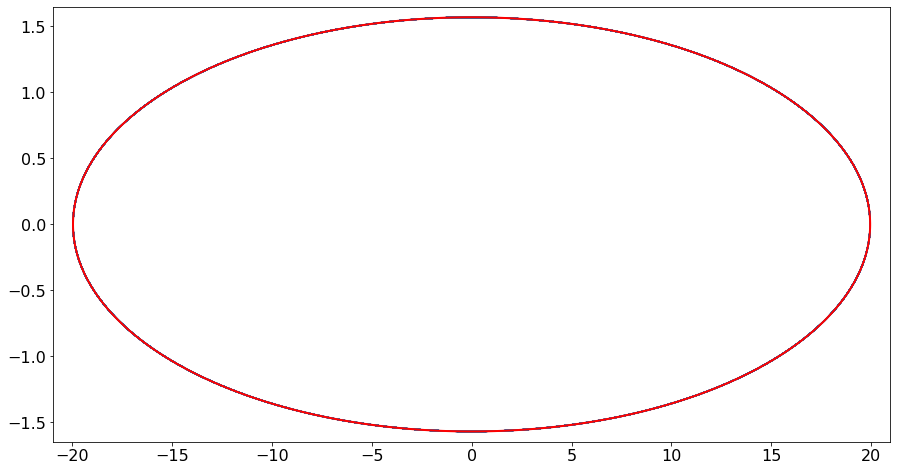

In [37]:
def func(t, A, fin, phi, P):
    a = A*np.sin(2*math.pi*fin*t + phi) + P
    b = 0#A*np.sin(2*math.pi*fin*t + phi)**2 + P
    return a + b

A1 = 10
A2 = 10
fin1 = 250e6
fin2 = 250e6
phi1 = 0
phi2 = 0
P1 = 0
P2 = 0

t=np.linspace(0, 100e-9, 100000)
dt = 100e-12
x = func(t,      A1, fin1, phi1, P1) + func(t + dt, A2, fin2, phi2, P2)
y = func(t + dt, A2, fin2, phi2, P2) - func(t,      A1, fin1, phi1, P1)

# Formulate and solve the least squares problem ||Ax - b ||^2
A = np.column_stack([x**2, x * y, y**2, x, y])
b = np.ones_like(x)
fit = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()

a = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]+math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
print("a = %f"%a)
b = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]-math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
print("b = %f"%b)

dtij = math.atan(min((a,b))/max((a,b)))/(math.pi*fin1)
print("dtij = %f ps"%(dtij*1e12))

theta = math.atan((fit[2]-fit[0]-math.sqrt((fit[2]-fit[0])**2+fit[1]**2))/fit[1])
print("angle = %f\n"%theta)

plt.plot(x, y)

# Plot the least squares ellipse
x_coord = np.linspace(1.05*x.min(),1.05*x.max(),300)
y_coord = np.linspace(1.05*y.min(),1.05*y.max(),300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = fit[0] * X_coord ** 2 + fit[1] * X_coord * Y_coord + fit[2] * Y_coord**2 + fit[3] * X_coord + fit[4] * Y_coord
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

(5, 256)


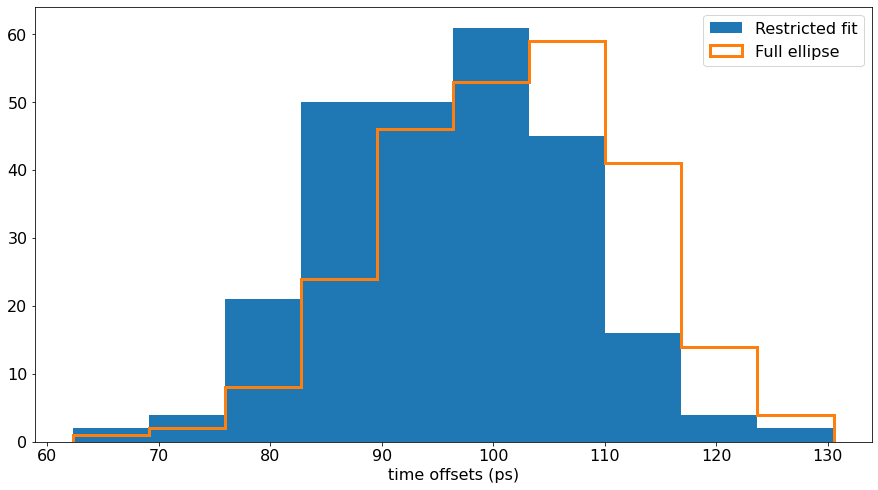

In [343]:
_, bins, _ = plt.hist(timeOffsets[1][:-1]*1e12, label="Restricted fit")
plt.hist(timeOffsets2[1][:-1]*1e12, bins=bins, histtype='step', linewidth=3, label="Full ellipse")
plt.legend()
plt.xlabel("time offsets (ps)")
print(timeOffsets.shape)

Text(0.5, 0, 'time difference (ps)')

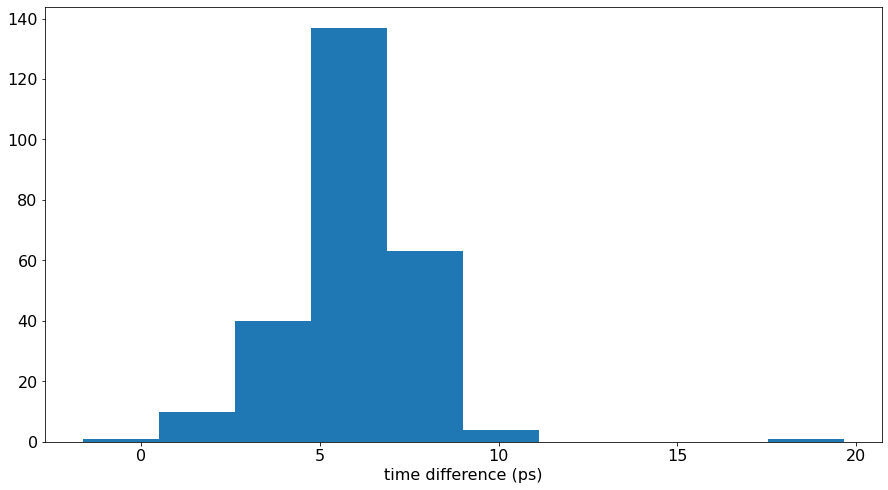

In [344]:
plt.hist((timeOffsets2[1]-timeOffsets[1])*1e12)
plt.xlabel("time difference (ps)")

25293.42452471538
25672.475766807092
25752.809738072665
25541.15618023134
25656.351218126845


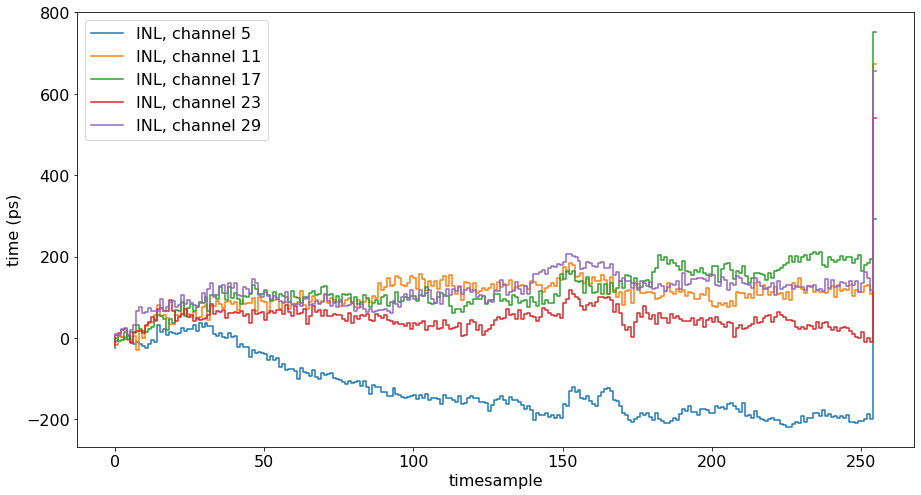

In [274]:
for iChan in range(0,5):
    ts_loc = timeOffsets[iChan]
    mean_ts = 25000e-12/256#ts_loc.mean()
    DNL = ts_loc[:] - mean_ts
    #plt.step(np.linspace(0, 255, 256), DNL*1e12, label="Differential non-linearity")
    INL = np.array([sum(DNL[:i+1]) for i in range(len(ts_loc))])
    plt.step(np.linspace(0, 255, 256), INL*1e12, label="INL, channel %i"%(iChan*6+5))
    plt.ylabel("time (ps)")
    plt.xlabel("timesample")
    plt.legend()
    print(sum(ts_loc)*1e12)

[ 0.55504864 -0.01459959  5.29814465 -0.07663249  0.01247214]
a = 1.344045
b = 0.435023
dtij = 398.557083 ps


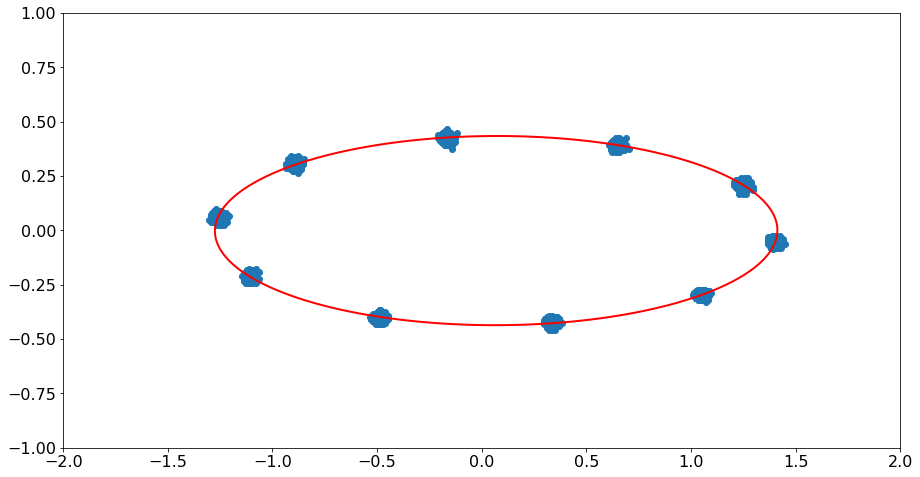

In [60]:
x_tsdata = []
y_tsdata = []
with open("tek0002CH2.csv") as f:
    for line in f:
        vals = line.split(",")
        if(len(vals) == 2):
            x_tsdata.append(float(vals[0]))
            y_tsdata.append(float(vals[1]))

x_tsdata = np.array(x_tsdata)
y_tsdata = np.array(y_tsdata)
            
x = y_tsdata[:-1] + y_tsdata[1:]
y = y_tsdata[:-1] - y_tsdata[1:]

# Formulate and solve the least squares problem ||Ax - b ||^2
A = np.column_stack([x**2, x * y, y**2, x, y])
b = np.ones_like(x)
fit = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()
print(fit)

a = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]+math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
print("a = %f"%a)
b = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]-math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
print("b = %f"%b)

dtij = math.atan(b/a)/(math.pi*250000000.0)
print("dtij = %f ps"%(dtij*1e12))
plt.scatter(x, y)

# Plot the least squares ellipse
x_coord = np.linspace(-2,2,300)
y_coord = np.linspace(-1,1,300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = fit[0] * X_coord ** 2 + fit[1] * X_coord * Y_coord + fit[2] * Y_coord**2 + fit[3] * X_coord + fit[4] * Y_coord
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

In [61]:
x_tsdata = np.array(x_tsdata)
y_tsdata = np.array(y_tsdata)

popt=(0.75, 0.0, 1.50/1e-9, 0.0)
popt, pcov = scipy.optimize.curve_fit(sine, x_tsdata[50:60], y_tsdata[50:60], p0=popt)
popt, pcov = scipy.optimize.curve_fit(sine, x_tsdata[0:100], y_tsdata[0:100], p0=popt)
print(*popt)

diff = y_tsdata - sine(x_tsdata, *popt)

plt.plot(x_tsdata[:200], y_tsdata[:200])

x_sim = np.linspace(x_tsdata[:200].min(), x_tsdata[:200].max(), 2000)
plt.plot(x_sim, sine(x_sim, *popt), label="sine fit")

plt.plot(x_tsdata[:200], diff[:200])

AttributeError: module 'scipy' has no attribute 'optimize'

(100, 30, 256) 1455.91


Text(0.5, 0, 'Pedestal ADC')

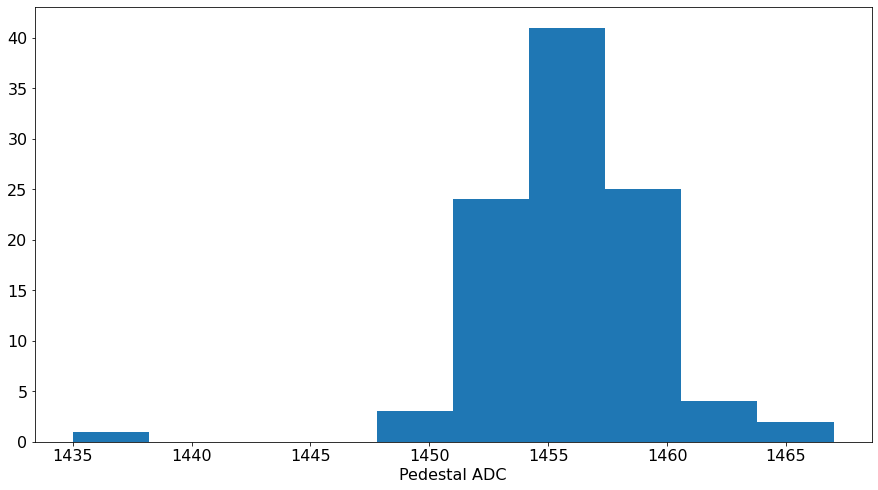

In [405]:
pedestal = 0x580
channel = 24
cap = 25

_, pdl = getDataRaw("data/Raw_testData_scan_pedestals_%i_20220915_164139_b0.txt"%pedestal)

print(pdl.shape, pdl[:,channel,cap].mean())
plt.hist(pdl[:,channel,cap])#-averages[channel,:])
plt.xlabel("Pedestal ADC")
#plt.plot(pdl[0,11,:]-averages[:,11])

In [4]:
means = []
x_vals = [i for i in range(0x10, 0xfff, 0x10)]
for i in x_vals:
    if i % 0x100 == 0: print(i)
    _, _, pedData = getDataRaw(["data/Raw_CounterTest_scan_pedestals_%i_20230927_133741_b1.txt"%i])
    means.append(pedData.mean(0))
means = np.array(means)

data/Raw_CounterTest_scan_pedestals_16_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_32_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_48_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_64_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_80_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_96_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_112_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_128_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_144_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_160_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_176_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_192_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_208_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_224_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_240_20230927_133741_b1.txt
256
data/Raw_CounterTest_scan_pedestals_256_20230927_133741_b

data/Raw_CounterTest_scan_pedestals_2112_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_2128_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_2144_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_2160_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_2176_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_2192_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_2208_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_2224_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_2240_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_2256_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_2272_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_2288_20230927_133741_b1.txt
2304
data/Raw_CounterTest_scan_pedestals_2304_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_2320_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals_2336_20230927_133741_b1.txt
data/Raw_CounterTest_scan_pedestals

Text(0, 0.5, 'measured ADC')

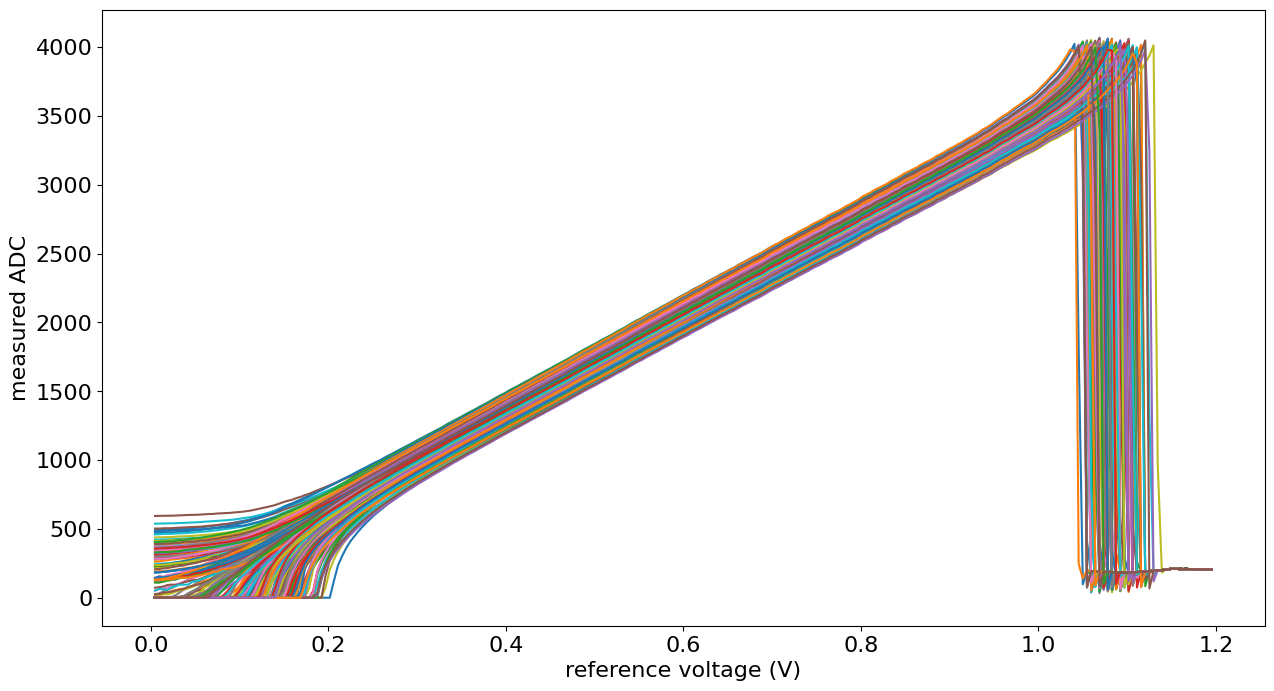

In [35]:
refVoltage = np.array([(float(i)/(2**12))*1.2 for i in x_vals])

channel = 29

for i in range(256):
    meanList = np.array([mean[channel,i] for mean in means])
    plt.plot(refVoltage, meanList)
    
plt.xlabel("reference voltage (V)")
plt.ylabel("measured ADC")

In [251]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except(ValueError, msg):
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [252]:
refVoltage = np.array([(float(i)/(2**12))*1.2 for i in range(0x10, 0xfff, 0x10)])

def lineraize_wrap(f, val):
    try:
        return f(val)
    except(ValueError):
        if val < 2000:
            return 0
        else:
            return 1.2

vlineraize_wrap = np.vectorize(lineraize_wrap)
        
voltageLin = []
for j in range(0, 30):
    voltageLin.append([])
    for i in range(0, 256):
        meanList = means[:,j,i]
        meanList = savitzky_golay(meanList, 21, 4)
        voltageLin[j].append(scipy.interpolate.interp1d(meanList, refVoltage))
        

In [253]:
xv = np.array([adc for adc in range(4096)])
#yv = vlineraize_wrap(voltageLin[6][0], xv)

linDat = []
for j in range(0, 30):
    for i in range(0, 256):
        linDat.append(vlineraize_wrap(voltageLin[j][i], data[:,j,i]))
linDat = np.vstack(linDat).transpose().reshape([-1,30,256])

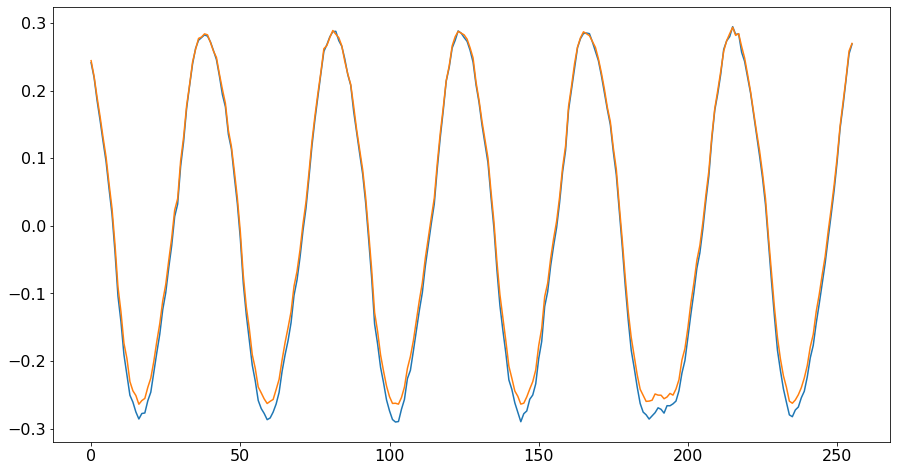

In [255]:
plt.plot((data[0,5,:]-averages[5,:])*1.2/4096)
plt.plot(linDat[0,5,:]-linDat[0,5,:].mean())

In [259]:
refVoltage = np.array([(float(i)/(2**12))*1.2 for i in x_vals])
for ichan in [5, 11, 17, 23, 29]:
    for iCap in range(256):
#for ichan in [5]:
#    for iCap in range(3):
        cap1 = iCap
        cap2 = (iCap+1)%256
        channel = ichan

        ydata = data[:1000]-averages
        tdata = times_320[:1000]
        #ydata = linDat

        upper = ((((tdata+4+1)%8)*32+16+8)%256)
        lower = ((((tdata+4+1)%8)*32-24+256)%256)
        ugtl = upper > lower

        ydata = ydata[ugtl & (np.logical_not((cap1 >= lower) & (cap2 <= upper))) 
                      | ((cap1 == 255) & ((lower < 204) & (upper < 204)))]


        x = ydata[:,channel,cap2] + ydata[:,channel,cap1]
        y = ydata[:,channel,cap1] - ydata[:,channel,cap2]

        xmin = x.min()
        xmax = x.max()
        y_fit = y[(x > xmax*0.5) | (x < xmin*0.5)]
        x_fit = x[(x > xmax*0.5) | (x < xmin*0.5)]
        #y = y[(x > 4) | (x < 2.3)]
        #x = x[(x > 4) | (x < 2.3)]

        # Formulate and solve the least squares problem ||Ax - b ||^2
        A = np.column_stack([x_fit**2, x_fit * y_fit, y_fit**2, x_fit, y_fit])
        b = np.ones_like(x_fit)
        fit = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()
        #print(fit)

        plt.clf()
        
        fig, ax = plt.subplots(2,2)
        
        ax[0,1].scatter(x, y)

        # Plot the least squares ellipse
        x_coord = np.linspace(1.05*x.min(),1.05*x.max(),300)
        y_coord = np.linspace(1.05*y.min(),1.05*y.max(),300)
        X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
        Z_coord = fit[0] * X_coord ** 2 + fit[1] * X_coord * Y_coord + fit[2] * Y_coord**2 + fit[3] * X_coord + fit[4] * Y_coord
        ax[0,1].contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)
        ax[0,1].set_xlabel("Vi + Vj")
        ax[0,1].set_ylabel("Vi - Vj")
        
        
        _, bins, _ = ax[0,0].hist(ped_data[:,channel,cap1])
        ax[0,0].hist(ped_data[:,channel,cap2], histtype='step', linewidth=3)
        ax[0,0].set_xlabel("pedestal adc value")

        _, bins, _ = ax[1,0].hist(data[:,channel,cap1])
        ax[1,0].hist(data[:,channel,cap2], histtype='step', linewidth=3)
        ax[1,0].set_xlabel("sinewave adc value")
        
        for i in [cap1,cap2]:#range(256):
            meanList = np.array([mean[channel,i] for mean in means])
            ax[1,1].plot(refVoltage, meanList)

        ax[1,1].set_xlabel("reference voltage (V)")
        ax[1,1].set_ylabel("measured ADC")

        fig.tight_layout()
        fig.savefig("Ellipse_chan_%i_cap_%i.png"%(ichan, cap1))
        plt.close(fig)
        

<Figure size 1080x576 with 0 Axes>

972.3077791810932 -13.06023434046942 0.14729237814801824 -7.70303954554642
mse: 0.656317


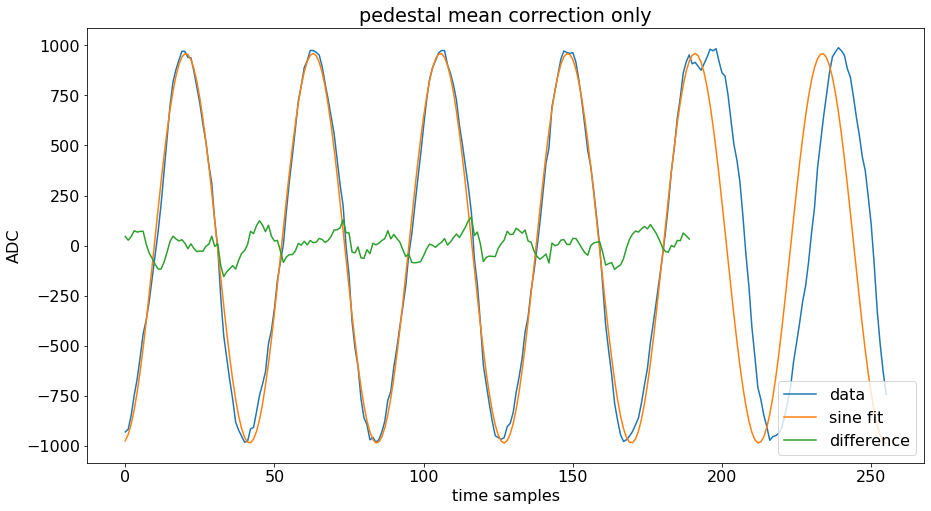

In [260]:
event = 15
channel = 5

xdata = np.linspace(0, 255,256)
ydata = data[event,channel,:]-averages[channel,:]
#ydata = linDat[event, :, 5]

popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(1000.0, 0.0, 1.0/20, 0.0))
popt, pcov = scipy.optimize.curve_fit(sine, xdata[0:170], ydata[0:170], p0=popt)
print(*popt)

diff = (ydata - sine(xdata, *popt))/popt[0]
pmco_diff = diff
print("mse: %f"%((diff**2)[:190].sum()))

plt.title("pedestal mean correction only")
plt.xlabel("time samples")
plt.ylabel("ADC")

plt.plot(xdata, ydata, label="data")

plt.plot(xdata, sine(xdata, *popt), label="sine fit")

plt.plot(xdata[:190], diff[:190]*1000, label="difference")

plt.legend(loc="lower right")

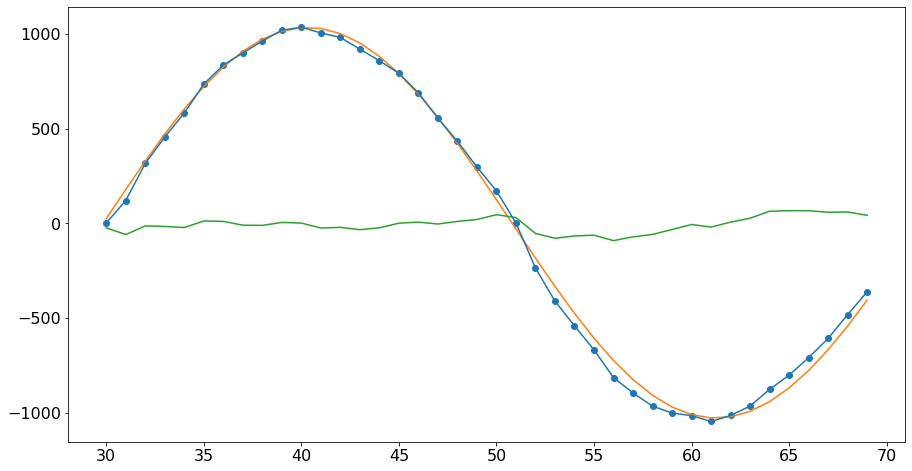

In [43]:
plt.scatter(xdata[30:70], ydata[30:70], label="data")
plt.errorbar(xdata[30:70], ydata[30:70], yerr=3, label="data")

plt.plot(xdata[30:70], sine(xdata[30:70], *popt), label="sine fit")

plt.plot(xdata[30:70], diff[30:70]*popt[0], label="difference")

In [38]:
xdata = np.linspace(0, 255,256)
#ydata = sineData[event,:,5]-averages[:,5]
ydata = linDat[event, :, channel]

popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(2.0, 0.0, 1.0/20, 0.0))
popt, pcov = scipy.optimize.curve_fit(sine, xdata[0:190], ydata[0:190], p0=popt)
print(*popt)

diff = (ydata - sine(xdata, *popt))/popt[0]
vlo_diff = diff
print("mse: %f"%((diff**2)[:190].sum()))

plt.title("Voltage linearization only")
plt.xlabel("time samples")
plt.ylabel("Voltage (V)")

plt.plot(xdata, ydata, label="data")

plt.plot(xdata, sine(xdata, *popt), label="sine fit")

plt.plot(xdata[:190], diff[:190]*popt[0], label="difference")

plt.legend(loc="lower right")

ValueError: `ydata` must not be empty!

In [51]:
xdata = np.cumsum(timeOffsets)*1e9
ydata = data[event,channel,:]-averages[channel,:]
#ydata = linDat[event, :, 5]

#popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(400.0, 0.0, 1.0/5000, 0.0))
#popt, pcov = scipy.optimize.curve_fit(sine, xdata[0:190], ydata[0:190], p0=popt)
#print(*popt)

diff = (ydata - sine(xdata, *popt))/popt[0]
toco_diff = diff
print("mse: %f"%((diff**2)[:190].sum()))

plt.title("Time offset calibration only")
plt.xlabel("time (ns)")
plt.ylabel("ADC")

plt.plot(xdata, ydata, label="data")

#plt.plot(xdata, sine(xdata, *popt), label="sine fit")

#plt.plot(xdata[:190], np.abs(diff[:190]*1000), label="difference")

plt.legend(loc="lower right")

ValueError: operands could not be broadcast together with shapes (256,) (1280,) 

1
-0.1023912653719021 -0.007423412039230607 1.5038325623786257 -11.022060226113771
Frequency: 239.342386 MHz

mse: 0.005432


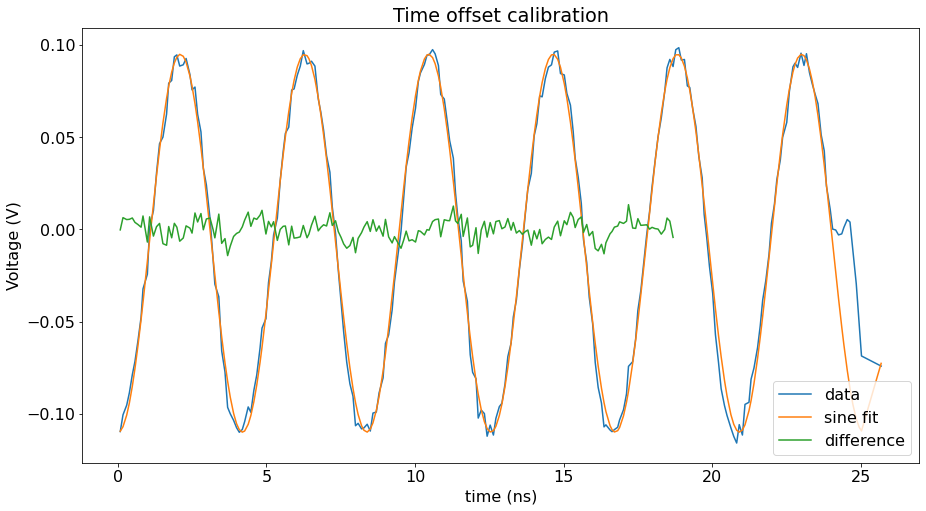

In [279]:
event = 22
channel = 11
iTO = int((channel-5)/6)
print(iTO)

#xdata = np.linspace(0, 25-0.4, 256)
xdata = np.cumsum(timeOffsets[iTO])*1e9#*timeOffsets[iTO].sum()*1e9/25
ydata = (data[event,channel,:]-averages[channel,:])*1.2/4096
#ydata = linDat[event, channel, :]

popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(0.2, 0.0, 1.0/20, 0.0))
popt, pcov = scipy.optimize.curve_fit(sine, xdata[0:190], ydata[0:190], p0=popt)
print(*popt)

print("Frequency: %f MHz\n"%(1000*abs(popt[2])/(2*math.pi)))

diff = (ydata - sine(xdata, *popt))
all_diff = diff
print("mse: %f"%((diff**2)[:190].sum()))

plt.title("Time offset calibration")
plt.xlabel("time (ns)")
plt.ylabel("Voltage (V)")

plt.plot(xdata, ydata, label="data")

plt.plot(xdata, sine(xdata, *popt), label="sine fit")

plt.plot(xdata[:190], diff[:190], label="difference")

plt.legend(loc="lower right")

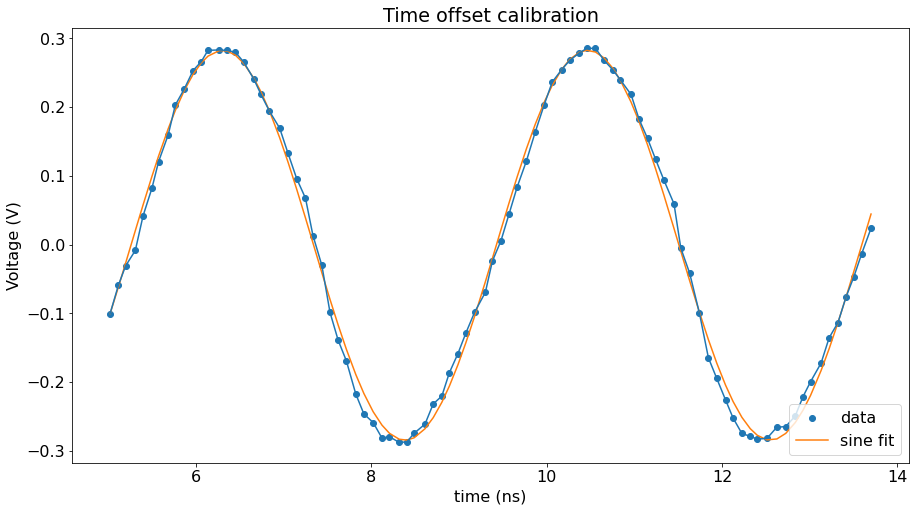

In [270]:
t = 20
s = slice(30+t,120+t)

plt.scatter(xdata[s], ydata[s], label="data")
plt.errorbar(xdata[s], ydata[s], yerr=3*1.2/4096)

plt.plot(xdata[s], sine(xdata[s], *popt), label="sine fit")

#plt.plot(xdata[s], diff[s], label="difference")

plt.title("Time offset calibration")
plt.xlabel("time (ns)")
plt.ylabel("Voltage (V)")
plt.legend(loc="lower right")

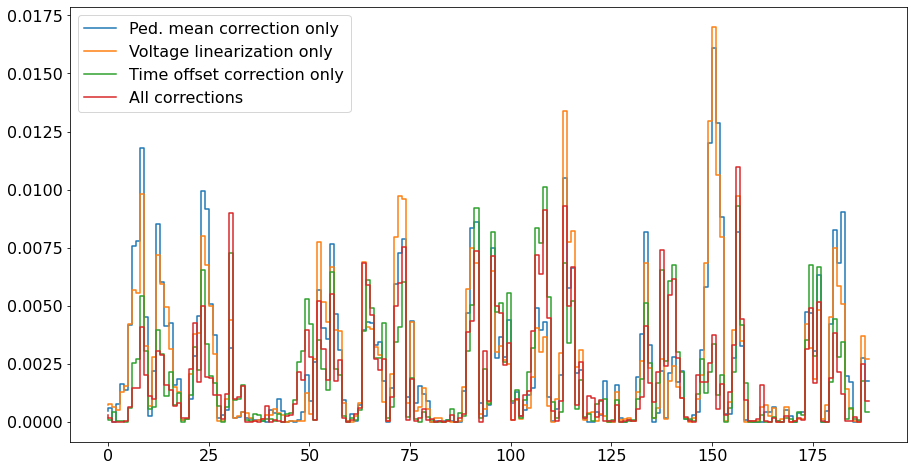

In [48]:
xdat = np.linspace(0, 189, 190)
plt.step(xdat,pmco_diff[:190]**2, label="Ped. mean correction only")
plt.step(xdat,vlo_diff[:190]**2, label="Voltage linearization only")
plt.step(xdat,toco_diff[:190]**2, label="Time offset correction only")
plt.step(xdat,all_diff[:190]**2, label="All corrections")
plt.legend()

[202 244]
   extrema [202.13331742 209.38638142 210.02662769 212.1928811  212.76866415]
bs extrema [-1417.03945361 -1018.89164093 -1025.4794653   -867.09479887
  -875.71834283]
se extrema 202.1333174211497
   extrema [232.66183439 243.54557713 245.88879931 246.68592403]
bs extrema [ -313.06505589 -1291.09445608 -1271.64562525 -1280.22663719]
se extrema 243.54557712572404
4.044165986774839
4.1015625
[23.78374777 19.73958178]
[19.7265625 23.828125 ]


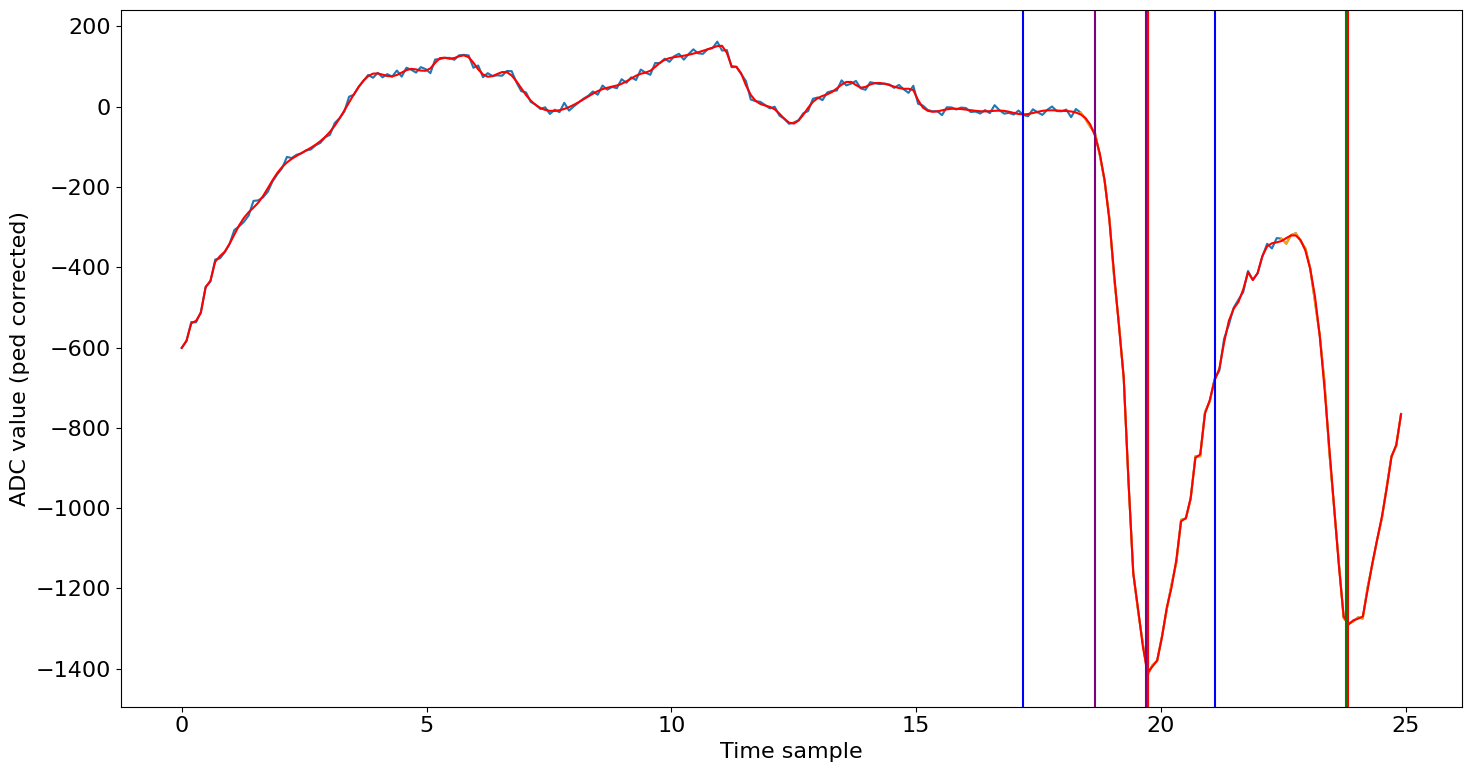

In [93]:
event = 0

xdata = np.linspace(0, 255,256)
ydata = data[event,:,:]-averages[:,:]

channel = ydata.min(axis=1).argmin()

ydata = ydata[channel]

peaks2 = scipy.signal.find_peaks(-1*ydata, height=(-0.5)*ydata.min(), distance = 20)[0]

peaks = []
csl = []
print(peaks2)
for xp1 in peaks2:
    #xp1 = peaks2.min()
    xp1Cut = (xdata > (xp1-15)) & (xdata < (xp1+15))
    spl = splrep(xdata[xp1Cut], ydata[xp1Cut], k=3)
    bs = BSpline(*spl)
    dbs = bs.derivative()
    #print(dcs.solve(0))
    xplot = np.linspace(xp1-15, xp1+15, 100)
    dcs = CubicSpline(xplot, dbs(xplot))
    extrema = dcs.solve(0)
    extrema = extrema[(extrema > (xp1-12)) & (extrema < (xp1+12))]
    print("   extrema", extrema)
    print("bs extrema", bs(extrema))
    extrema = extrema[bs(extrema).argsort()][0]
    print("se extrema", extrema)
    peaks.append(extrema)
    csl.append((xdata[xp1Cut], bs))
peaks = np.array(peaks)
peaks = peaks[(peaks > 0) & (peaks < 256)]
peaks = peaks[np.argsort(bs(peaks))[:2]]

peaks = peaks*25/256
peaks2 = peaks2*25/256

try:
    print(peaks.max()-peaks.min())
    print(peaks2.max()-peaks2.min())
except:
    pass

print(peaks)
print(peaks2)

cw_low = (((times_320[event]+3+1)%8)*32-16)%256*25/256
cw_high = (((times_320[event]+3+1)%8)*32+24)%256*25/256

spl2 = splrep(xdata, ydata, k=3, s=10000)
bs2 = BSpline(*spl2)

fig, (ax1) = plt.subplots(1, 1)
ax1.plot(xdata*25/256, ydata, label="Pulse %i"%i)
for x, bs in csl:
    ax1.plot(x*25/256, bs(x), label="Pulse %i"%i, color='orange')
#ax1.plot(xplot, dbs(xplot))
#ax1.plot(xplot, dcs(xplot))

ax1.plot(xdata*25/256, bs2(xdata), label="Pulse %i"%i, color='red')

for x in peaks:
    ax1.axvline(x, color="green")

for x in peaks2:
    ax1.axvline(x, color="red")
    
ax1.axvline(18.945491924687623-0.3, color="purple")
ax1.axvline(19.399519235633772+0.3, color="purple")

ax1.axvline(cw_high, color="blue")
ax1.axvline(cw_low, color="blue")
ax1.set_xlabel("Time sample")
ax1.set_ylabel("ADC value (ped corrected)")

fig.tight_layout()

<timed exec>:108: RuntimeWarning: invalid value encountered in double_scalars


Skipped:  224
CPU times: user 9.88 s, sys: 59.1 ms, total: 9.94 s
Wall time: 9.94 s


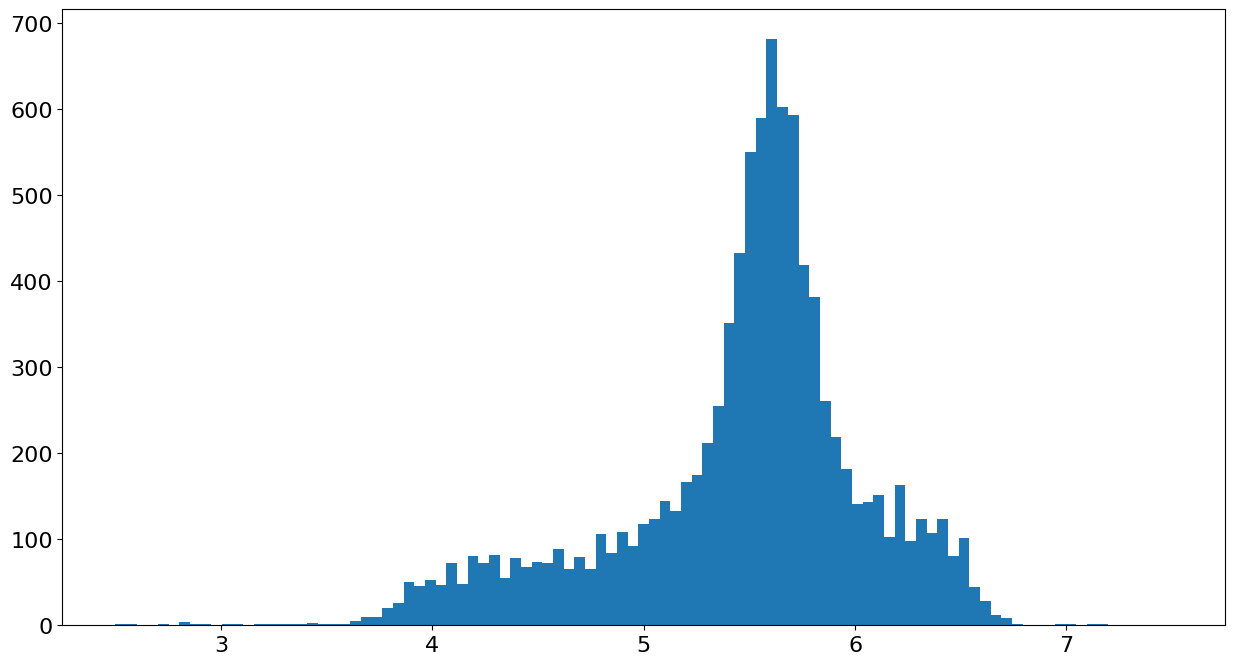

In [8]:
%%time

deltaT = 0.10
timerange = 20

def find_leading_edge(xdata, ydata, display=False, SPLINE_CFD=False):

        # Determines the indices of the peaks in the prompt and reflected pulses                                                                                                                                                              
        height_cutoff = -0.6*ydata.max()
        distance_between_peaks = 20             # in units of indices                                                                                                                                                                         
        peak_region_radius = 15                 # in units of indices                                                                                                                                                                         
        peaks_rough = scipy.signal.find_peaks(-1*ydata, height=height_cutoff, distance=distance_between_peaks)[0]
        prompt_peak_index, reflect_peak_index = np.sort(peaks_rough[ydata[peaks_rough].argsort()[0:2]])

        # Creates subregions of data around the reflect peak                                                                                                                                                                                  
#        reflect_lbound = reflect_peak_index - int((reflect_peak_index-prompt_peak_index)/2)-5 # lower bound is a bit left of the midway between peaks                                                                                         
#        reflect_ubound = reflect_peak_index + 6
#        ydata_subrange = ydata[reflect_lbound:reflect_ubound]
#        reflect_subdomain = xdata[reflect_lbound:reflect_ubound]
#        peak_region_lower, peak_region_upper = xdata[reflect_peak_index-4], xdata[reflect_peak_index+4]
#
#        # Solves for the extrema of the reflect peak                                                                                                                                                                                          
#        # spline_tuple = splrep(reflect_subdomain, ydata_subrange, k=3, s=10000)                                                                                                                                                              
#        spline_tuple = splrep(reflect_subdomain, ydata_subrange, k=3)
#        reflect_bspline = BSpline(*spline_tuple)
#        reflect_dbspline = reflect_bspline.derivative()
#        reflect_dcubic_spline = CubicSpline(reflect_subdomain, reflect_dbspline(reflect_subdomain))
#        extrema = reflect_dcubic_spline.solve(0, extrapolate=False)
#        reflect_peak_max = reflect_bspline(extrema[(extrema > peak_region_lower) & (extrema < peak_region_upper)])      # finds the extrema that is near our original find_peaks value                                                        
#        reflect_peak_max = reflect_peak_max[0]
#        reflect_peak_min_val = reflect_bspline(extrema[0]) + 0.1*(reflect_peak_max - reflect_bspline(extrema[0]))

        # repeating the spline for the prompt peak now                                                                                                                                                                                        
        prompt_lbound = prompt_peak_index - 20
        if prompt_lbound < 0:
                prompt_lbound = 0
        prompt_ubound = prompt_peak_index + 4
        prompt_subrange = ydata[prompt_lbound:prompt_ubound]
        prompt_subdomain = xdata[prompt_lbound:prompt_ubound]
        # prompt_tuple = splrep(prompt_subdomain, prompt_subrange, k=3, s=10000)                                                                                                                                                              
        prompt_tuple = splrep(prompt_subdomain, prompt_subrange, k=3)
        prompt_bspline = BSpline(*prompt_tuple)
        prompt_cubic_spline = CubicSpline(prompt_subdomain, prompt_bspline(prompt_subdomain))
        prompt_dbspline = prompt_bspline.derivative()
        prompt_dcubic_spline = CubicSpline(prompt_subdomain, prompt_dbspline(prompt_subdomain))
        prompt_extrema = prompt_dcubic_spline.solve(0)
        peak_region_lower, peak_region_upper = xdata[prompt_peak_index-3], xdata[prompt_peak_index+3]
        prompt_peak_max = prompt_bspline(prompt_extrema[(prompt_extrema > peak_region_lower) & (prompt_extrema < peak_region_upper)])
        prompt_peak_max = prompt_peak_max[0]

        # Computes the integral bounds                                                                                                                                                                                                        
        lbound = prompt_cubic_spline.solve(0.10*prompt_peak_max, extrapolate=False)[0]
        rbound = prompt_cubic_spline.solve(0.95*prompt_peak_max, extrapolate=False)[0]

        if SPLINE_CFD:
                reflect_cubicspline = CubicSpline(reflect_subdomain, reflect_bspline(reflect_subdomain))
                r_intersects = reflect_cubicspline.solve(reflect_peak_min_val, extrapolate=False)
                reflect_cfd_pos = (r_intersects[r_intersects < xdata[reflect_peak_index]])[-1]
                return lbound, reflect_cfd_pos
        else:
                return lbound, rbound, prompt_cubic_spline

        

def findDiscValues(x, y, offsets):
    #create splines and find rising edge
    spl = splrep(x, y, k=3)
    bs = BSpline(*spl)
    low, high, _ = find_leading_edge(x, y)
    low -= 0.1
    high += 0.1
    
    #select x/y values of interest
    cut = (x > low) & (x < high)
    x = x[cut]
    y = y[cut]
    allTimes = []
    for dt in offsets:
        allTimes.append(x+dt)
    xs = np.vstack(allTimes).reshape([-1, x.shape[0]])
    
    y_shift = bs(xs)
    
    discArray = (y_shift - y)**2
    #discArray = np.abs(y_shift - y)
    #discArray = -y_shift*y
    discriminator = scipy.integrate.trapezoid(discArray, x, axis=1)
    
    return discriminator
    
def calcDeltaT(xdata, ydata):
    #find offsets between peaks 
    skipped = 0
    dt_vals = []
    s = slice(None)
    offsets = np.arange(0, timerange, deltaT)
    for xd, yd in zip(xdata[s], ydata[s]):
        try:
            disc = findDiscValues(xd, yd, offsets)
            #plt.plot(offsets, disc)

            #course grained minimum location
            cut = (offsets > 2.5) & (offsets < 15)
            extrema = offsets[cut][disc[cut].argmin()]

            #fine tune min location
            cut = (offsets > extrema-0.5) & (offsets < extrema+0.5)
            domain = [extrema-0.5, extrema+0.5]
            poly = np.polynomial.polynomial.Polynomial.fit(offsets[cut], disc[cut], 2, domain = domain, window = domain)
            extrema = -poly.coef[1]/(2*poly.coef[2])
            #plt.axvline(extrema-0.5)
            #plt.axvline(extrema+0.5)
            #plt.plot(offsets[cut], poly(offsets[cut]))

            dt_vals.append(extrema)

        except:
            skipped += 1
            #raise
            
    return dt_vals, skipped

    
#make up fake time offsets 
xdata = []
for iChan in range(30):
    xdata.append(np.array([25.0/256]*256)+0.01*(np.random.rand(256)))
    xdata[iChan][255] += 0.300

#preprocess data
#Calibrate data
xdata = np.vstack(xdata)    
ydata = data[:,:,:]-averages[:,:]

#select desired channel and shift trigger window to start of time window 
channels = ydata.min(axis=2).argmin(axis=1)
trigOffset = 4
cw_low = (((times_320+trigOffset)%8)*32-16)%256
#cw_high = (((times_320+trigOffset)%8)*32+24)%256

xdata = xdata[channels]

xdata = np.array([np.roll(np.copy(xdata[i]), -cw_low[i]) for i in range(channels.shape[0])])
xdata = np.cumsum(xdata, axis=1)

ydata = np.array([np.roll(ydata[i, channels[i]], -cw_low[i])  for i in range(channels.shape[0])])

#xdata = [np.cumsum(np.roll(np.copy(xdata[i]), -cw_low[i])) for i in range(channels.shape[0])]
#ydata = [np.roll(ydata[i, channels[i]], -cw_low[i])  for i in range(channels.shape[0])]

#calculate dt values
#with Pool(5) as p:
#    rv = p.starmap(calcDeltaT, zip(xdata, ydata))
#print(rv)

dt_vals, skipped = calcDeltaT(xdata, ydata)

plt.hist(dt_vals, bins=np.linspace(2.5, 7.5, 100))

print("Skipped: ", skipped)

